In [1]:
from pathlib import Path
import json
from src.similarity import load_similarity_matrix
from omegaconf import OmegaConf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import matplotlib.colors as mcolors
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    auc
)
from functools import wraps
from typing import Iterable
from collections import defaultdict

seed = 1234
n_bs = 20
rng = np.random.default_rng(seed)

def bootstrap_metric(metric: callable, rng: np.random.Generator, n_bootstraps: int = 20) -> callable:
    """Bootstrap a metric calculation.

    Args:
        y_true (np.ndarray): True binary labels.
        y_pred_or_probas (np.ndarray): Predicted binary labels or probabilities.
        metric (callable): Metric function to be bootstrapped. Should take y_true and y_pred as arguments.
        threshold (float, optional): Threshold to convert probabilities to binary labels. If None, y_pred_or_probas is assumed to be binary labels. Defaults to None.
        n_bootstraps (int, optional): Number of bootstrap samples. Defaults to 20.

    Returns:
        callable: A function that computes the bootstrapped metric and its 95% confidence interval.
    """
    @wraps(metric)
    def wrapper(y_true: Iterable[int], y_pred_or_probas: Iterable[float | int], threshold: float | None = None, n_bootstraps: int = n_bootstraps, rng: np.random.Generator = rng, *args, **kwargs) -> tuple[float, tuple[float, float]]:
        boot_metrics = []
        n = len(y_true)
        for _ in range(n_bootstraps):
            indices = rng.integers(0, n, n)
            if threshold is not None:
                y_pred_sample = (y_pred_or_probas[indices] >= threshold).astype(int)
            else:
                y_pred_sample = y_pred_or_probas[indices]
            y_true_sample = y_true[indices]
            boot_metric = metric(y_true_sample, y_pred_sample, *args, **kwargs)
            boot_metrics.append(boot_metric)
        boot_metrics = np.array(boot_metrics)
        mean_metric = np.mean(boot_metrics)
        lower_ci = np.percentile(boot_metrics, 2.5)
        upper_ci = np.percentile(boot_metrics, 97.5)
        return mean_metric, (lower_ci, upper_ci)
    return wrapper


def get_shades(color, n_shades=6):
    base_color = mcolors.to_rgba(color)
    return [mcolors.to_hex((base_color[0], base_color[1], base_color[2], base_color[3] * (i / n_shades))) for i in range(1, n_shades + 1)]

filepaths = OmegaConf.load("../configs/filepaths/base.yaml")
mlflow.set_tracking_uri(filepaths.tracking_uri)

discrete_metrics = {
    'f1': bootstrap_metric(f1_score, rng, n_bootstraps=n_bs),
    'binary_precision': bootstrap_metric(precision_score, rng, n_bootstraps=n_bs),
    'binary_recall': bootstrap_metric(recall_score, rng, n_bootstraps=n_bs),
    'accuracy': bootstrap_metric(accuracy_score, rng, n_bootstraps=n_bs),
}

continuous_metrics = {
    'roc_auc': bootstrap_metric(roc_auc_score, rng, n_bootstraps=n_bs),
}

def get_nm_indices(df: pd.DataFrame, neg_multiple: int, seed: int = seed) -> np.ndarray:
    _rng = np.random.default_rng(seed)
    neg_idxs = df[df['y'] == 0].index
    n_to_rm = len(neg_idxs) - (len(df[df['y'] == 1]) * neg_multiple)
 
    if n_to_rm <= 0:
        return np.array(df.index)
    n_to_keep = len(neg_idxs) - n_to_rm
    keep_idxs = _rng.choice(neg_idxs, size=n_to_keep, replace=False)
    all_idxs = np.concatenate((df[df['y'] == 1].index.to_numpy(), keep_idxs))
    return all_idxs

Wrangle top model run ids

In [2]:
filter_split = "params.'data/split_idx' = '-1'"

non_clip = mlflow.search_runs(
    filter_string=filter_split,
)
non_clip.head()

run_id experiment_id    status  \
0  000fc5f378954a27bf934ccd58241a57             0  FINISHED   
1  bafce811361c4d19afe7919fb4666fb2             0  FINISHED   
2  f1cf506a0c0f48b49bbf491f51db24f7             0  FINISHED   
3  c4fdab61494a4affb7b48b3f18b0a314             0   RUNNING   
4  a91ff6acc5a848f18a179c42f5127a85             0  FINISHED   

                                        artifact_uri  \
0  file:///projects/p30041/spn1560/hiec/results/r...   
1  file:///projects/p30041/spn1560/hiec/results/r...   
2  file:///projects/p30041/spn1560/hiec/results/r...   
3  file:///projects/p30041/spn1560/hiec/results/r...   
4  file:///projects/p30041/spn1560/hiec/results/r...   

                        start_time                         end_time  \
0 2025-12-16 14:56:07.389000+00:00 2025-12-16 15:05:19.408000+00:00   
1 2025-12-16 14:56:07.389000+00:00 2025-12-16 15:09:44.076000+00:00   
2 2025-12-16 14:56:07.389000+00:00 2025-12-16 15:22:51.397000+00:00   
3 2025-12-16 14:20:45.276000+00:00                              NaT   
4 2025-12-16 14:20:07.851000+00:00 2025-12-17 02:08:22.087000+00:00   

   metrics.val/prc  metrics.val/roc  metrics.val/binary_precision  \
0         0.495697         0.883600                      0.456721   
1         0.616520         0.914149                      0.651462   
2         0.385867         0.666661                      0.263972   
3         0.659538         0.908570                      0.481775   
4         0.532819         0.733257                      0.280344   

   metrics.val/f1  ...  params.warmup_epochs  params.batch_norm  \
0        0.478540  ...                  None               None   
1        0.567073  ...                  None               None   
2        0.357161  ...                  None               None   
3        0.602225  ...                  None               None   
4        0.409551  ...                  None               None   

   params.reduce_X_d  params.init_lr  params.X_d_transform  \
0               None            None                  None   
1               None            None                  None   
2               None            None                  None   
3               None            None                  None   
4               None            None                  None   

   params.model/radius tags.mlflow.source.type  \
0                 None                   LOCAL   
1                 None                   LOCAL   
2                 None                   LOCAL   
3                 None                   LOCAL   
4                 None                   LOCAL   

               tags.mlflow.source.name tags.mlflow.user   tags.mlflow.runName  
0  /home/spn1560/hiec/scripts/train.py          spn1560    sincere-grouse-632  
1  /home/spn1560/hiec/scripts/train.py          spn1560  adventurous-goat-103  
2  /home/spn1560/hiec/scripts/train.py          spn1560     colorful-tern-162  
3  /home/spn1560/hiec/scripts/train.py          spn1560      rumbling-koi-381  
4  /home/spn1560/hiec/scripts/train.py          spn1560     delicate-bird-607  

[5 rows x 55 columns]

In [10]:
id2name = {
    row['run_id']: {'data': row['params.data/split_strategy'], 'model': row['params.model/name']}
    for _, row in non_clip.iterrows()
}

id2name['clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold'] = {'data': 'rcmcs', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_drfp_outer_fold'] = {'data': 'drfp', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_esm_outer_fold'] = {'data': 'esm', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_random_reaction_outer_fold'] = {'data': 'random_reaction', 'model': 'clipzyme'}
id2name['clipzyme/sprhea_v3_folded_pt_ns_random_reaction_center_outer_fold'] = {'data': 'random_reaction_center', 'model': 'clipzyme'}
# id2name['clipzyme_egnn/sprhea_v3_folded_pt_ns_random_reaction_center_outer_fold'] = {'data': 'random_reaction_center', 'model': 'clipzyme_egnn'}

In [11]:
best_thresholds = {}
for id in id2name.keys():
    if not (Path(filepaths.results) / 'predictions' / id / 'best_thresholds.json').exists():
        print(f"No thresholds saved for {id2name[id]}, skipping...")
        continue
    
    with open(Path(filepaths.results) / 'predictions' / id / 'best_thresholds.json', 'r') as f:
        this = json.load(f)

    best_thresholds[id] = {int(k): v for k, v in this.items()}


In [12]:
preds = {} # Model outputs
nm_keep_indices = {} # Downsampled indices
chance = {}
cols = ['data', 'model', 'neg_multiple', 'metric', 'mean', 'ci_lower', 'ci_upper', 'id']
evals = []
for id in best_thresholds.keys():
    target_output_path = Path(filepaths.results) / 'predictions' / id / 'target_output.parquet'
    target_output = pd.read_parquet(target_output_path)
    preds[id] = target_output
    keep_indices = {
        nm : get_nm_indices(target_output, neg_multiple=nm, seed=seed)
        for nm in best_thresholds[id].keys()
    }

    nm_keep_indices[id] = keep_indices
    for nm in best_thresholds[id].keys():
        th = best_thresholds[id][nm]
        keep_idx = nm_keep_indices[id][nm]
        _target_output = target_output.loc[keep_idx]
        for metric_name, discrete_metric in discrete_metrics.items():
            mean, (ci_l, ci_u) = discrete_metric(_target_output['y'].to_numpy(), _target_output['logits'].to_numpy(), threshold=th)
            evals.append(
                [
                    id2name[id]['data'],
                    id2name[id]['model'],
                    nm,
                    metric_name,
                    mean,
                    ci_l,
                    ci_u,
                    id
                ]
            )

        for metric_name, continuous_metric in continuous_metrics.items():
            mean, (ci_l, ci_u) = continuous_metric(_target_output['y'].to_numpy(), _target_output['logits'].to_numpy())
            evals.append(
                [
                    id2name[id]['data'],
                    id2name[id]['model'],
                    nm,
                    metric_name,
                    mean,
                    ci_l,
                    ci_u,
                    id
                ]
            )

metrics_table = pd.DataFrame(
    evals, columns=cols
)

for _, row in metrics_table.drop_duplicates(['data', 'neg_multiple']).iterrows():
    _target_output = preds[row['id']].loc[nm_keep_indices[row['id']][row['neg_multiple']]]
    for metric in discrete_metrics.keys():
        mean, (ci_l, ci_u) = discrete_metrics[metric](_target_output['y'].to_numpy(), rng.integers(0, 2, size=len(_target_output)))
        chance[(row['data'], row['neg_multiple'], metric)] = mean

metrics_table.head()

data  model  neg_multiple            metric      mean  ci_lower  \
0  random_reaction  rxnfp             1                f1  0.762303  0.756011   
1  random_reaction  rxnfp             1  binary_precision  0.877243  0.870906   
2  random_reaction  rxnfp             1     binary_recall  0.672218  0.665041   
3  random_reaction  rxnfp             1          accuracy  0.788941  0.781617   
4  random_reaction  rxnfp             1           roc_auc  0.886177  0.882454   

   ci_upper                                id  
0  0.770053  000fc5f378954a27bf934ccd58241a57  
1  0.883384  000fc5f378954a27bf934ccd58241a57  
2  0.678269  000fc5f378954a27bf934ccd58241a57  
3  0.793420  000fc5f378954a27bf934ccd58241a57  
4  0.889128  000fc5f378954a27bf934ccd58241a57

In [13]:
# Filter for neg_multiple == 1
nm1_df = metrics_table[metrics_table['neg_multiple'] == 1].copy()

# Pivot to create columns for each metric
pivoted = nm1_df.pivot_table(
    index=['data', 'model'],
    columns='metric',
    values=['mean']
)

# Flatten column names to create mean_metric, ci_lower_metric, ci_upper_metric format
pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
pivoted = pivoted.reset_index()

pivoted.sort_values(by=['data', 'mean_roc_auc'], ascending=[True, False])

data     model  mean_accuracy  mean_binary_precision  \
0                     drfp  clipzyme       0.929129               0.929792   
1                      esm  clipzyme       0.926304               0.925412   
7          random_reaction    rc_agg       0.953177               0.943791   
3          random_reaction       cgr       0.947517               0.961054   
8          random_reaction    rc_cxn       0.936886               0.928488   
2          random_reaction       bom       0.832770               0.763553   
4          random_reaction  clipzyme       0.891780               0.868448   
5          random_reaction      drfp       0.854672               0.887019   
9          random_reaction     rxnfp       0.788941               0.877243   
6          random_reaction       mfp       0.767109               0.861961   
15  random_reaction_center    rc_agg       0.762735               0.810919   
16  random_reaction_center    rc_cxn       0.745457               0.752350   
11  random_reaction_center       cgr       0.755907               0.757732   
12  random_reaction_center  clipzyme       0.712726               0.690950   
13  random_reaction_center      drfp       0.694582               0.669048   
10  random_reaction_center       bom       0.674953               0.653933   
14  random_reaction_center       mfp       0.636900               0.640870   
17  random_reaction_center     rxnfp       0.497908               0.500808   
24                   rcmcs    rc_cxn       0.853577               0.900574   
23                   rcmcs    rc_agg       0.808637               0.912975   
20                   rcmcs  clipzyme       0.806846               0.884852   
19                   rcmcs       cgr       0.857197               0.919147   
25                   rcmcs     rxnfp       0.760567               0.930345   
18                   rcmcs       bom       0.807009               0.837753   
22                   rcmcs       mfp       0.727195               0.774276   
21                   rcmcs      drfp       0.501290               0.499167   

    mean_binary_recall   mean_f1  mean_roc_auc  
0             0.928685  0.929454      0.975705  
1             0.927862  0.926201      0.973415  
7             0.963890  0.953552      0.985690  
3             0.932380  0.946795      0.982250  
8             0.946841  0.937291      0.974524  
2             0.965488  0.852345      0.941603  
4             0.927532  0.896427      0.920636  
5             0.813561  0.848607      0.909816  
9             0.672218  0.762303      0.886177  
6             0.634641  0.732399      0.854315  
15            0.687810  0.744761      0.835281  
16            0.732891  0.741520      0.820006  
11            0.752408  0.754938      0.807079  
12            0.774939  0.730259      0.763861  
13            0.774989  0.714940      0.730953  
10            0.749575  0.696563      0.725214  
14            0.620333  0.632980      0.675144  
17            1.000000  0.666672      0.662431  
24            0.795067  0.843131      0.939768  
23            0.690945  0.784015      0.937922  
20            0.708204  0.788453      0.928589  
19            0.781528  0.845293      0.916182  
25            0.564745  0.701222      0.915477  
18            0.764722  0.798018      0.908922  
22            0.645785  0.703402      0.751599  
21            1.000000  0.667827      0.723525

# Plotting

In [14]:
# Overall style

save_to = Path(filepaths.artifacts) / "figures" / "performance"

labels = {
    "rc_agg": "RC aggregated",
    "rc_cxn": "RC connected",
    "bom": "Bag of molecules",
    "cgr": "CGR",
    "clipzyme": "CLIPZyme",
    "rxnfp": "RXNFP",
    "drfp": "DRFP",
    "mfp": "Morgan fingerprint",
}

get_model_order = lambda x : [list(labels.keys()).index(elt) for elt in x]

colors = {
    "rc_agg": "purple",
    "rc_cxn": "forestgreen",
    "bom": "mediumblue",
    "cgr": "saddlebrown",
    "rxnfp": "silver",
    "mfp": "black",
    "drfp": "dimgray",
    "clipzyme": "maroon",
}

metrics = {
    'f1': f1_score,
    'binary_precision': precision_score,
    'binary_recall': recall_score,
    'accuracy': accuracy_score
}

metric_names = {
    'f1': "F1",
    'binary_precision': "Precision",
    'binary_recall': "Recall",
    'accuracy': "Accuracy",
    'roc_auc': "ROC-AUC"
}

similarity_names = {
    'rcmcs': "RCMCS",
    'homology': "GSI",
    'drfp': "DRFP",
    'esm': "ESM",
    'random_reaction': "Random reaction",
    'random_reaction_center': "Random reaction center",
    'gsi': "GSI <25%"
}

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.titlesize": 16,
})

ROC curves

In [15]:
figsize = (10, 5)
width = 0.75  # the width of the bars
xtick_rot = 45
xtick_ha = 'right'
ylim = (0.5, 1.0)

DRFP - Negative multiple 1


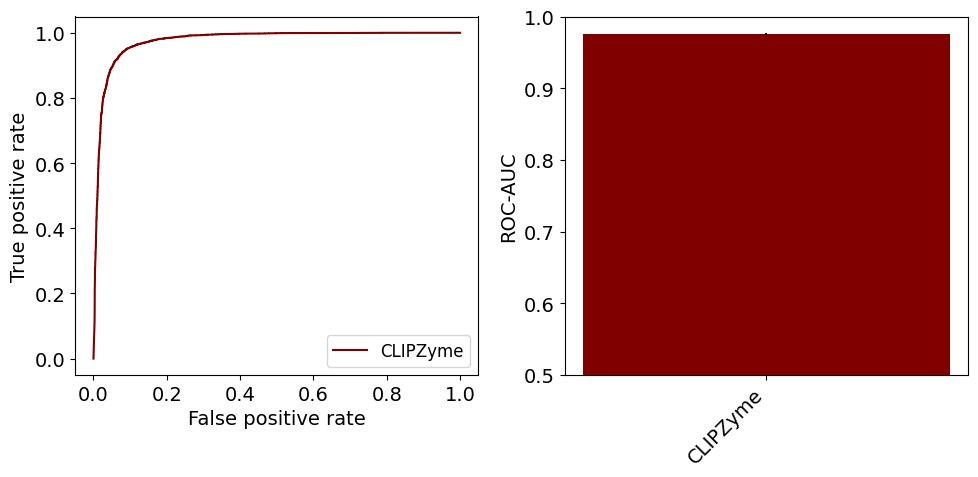

DRFP - Negative multiple 3


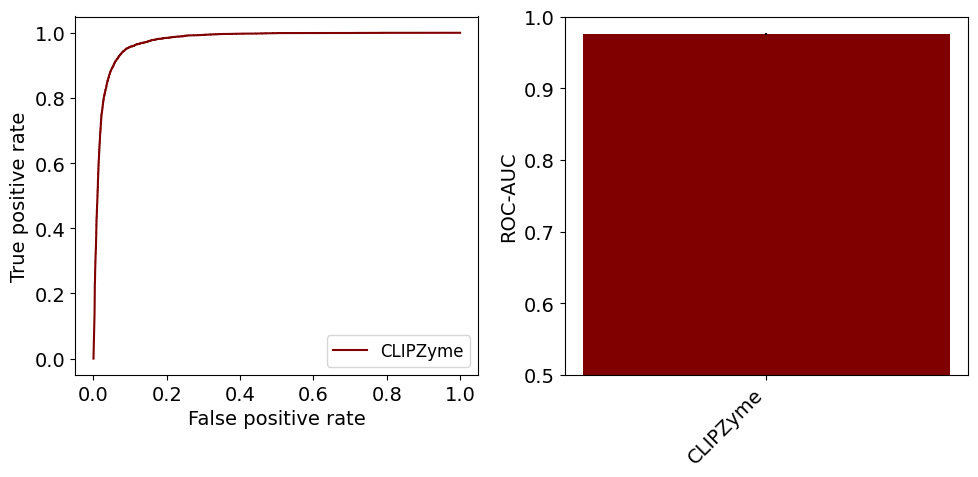

DRFP - Negative multiple 5


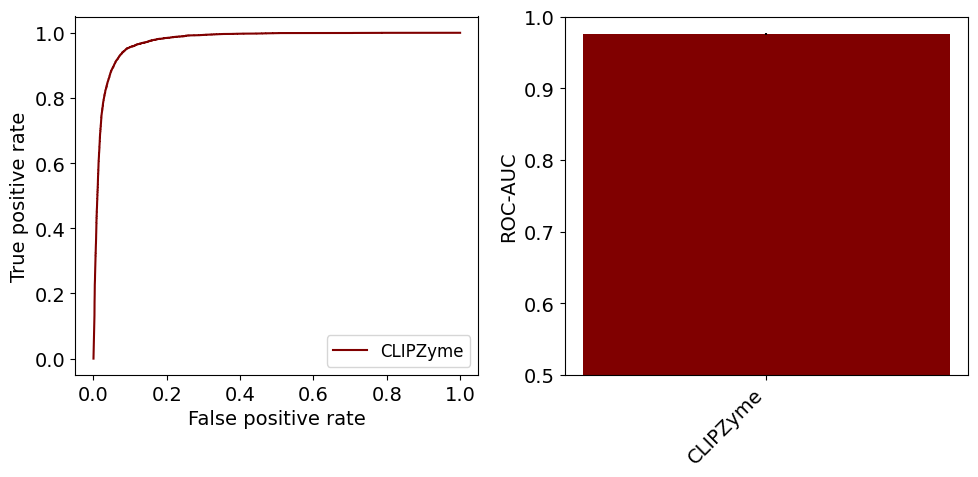

DRFP - Negative multiple 10


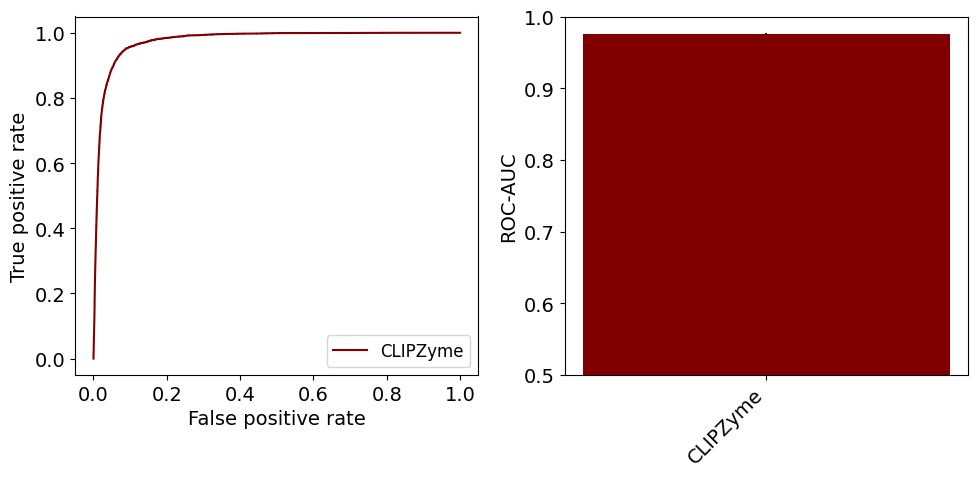

ESM - Negative multiple 1


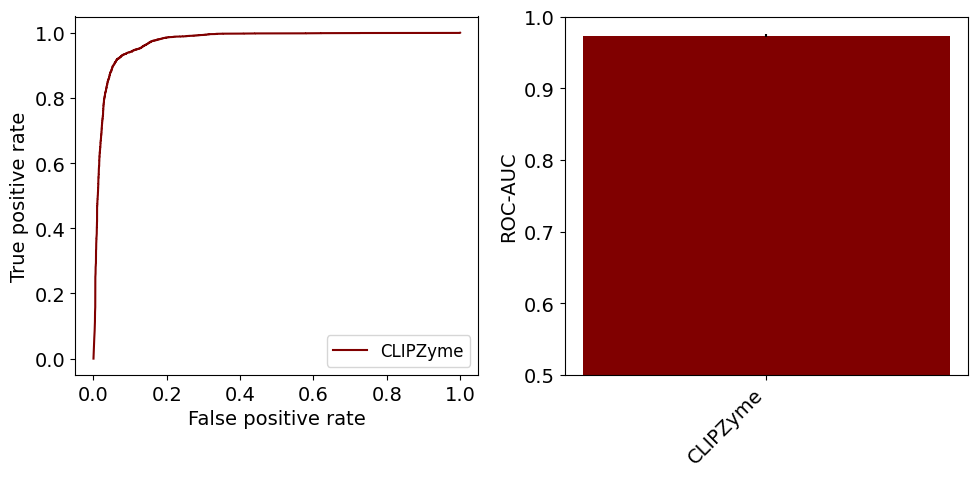

ESM - Negative multiple 3


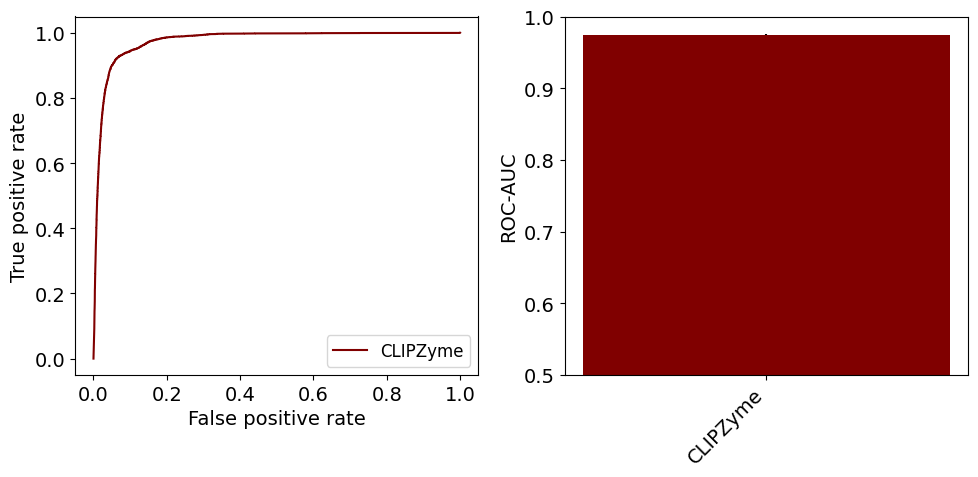

ESM - Negative multiple 5


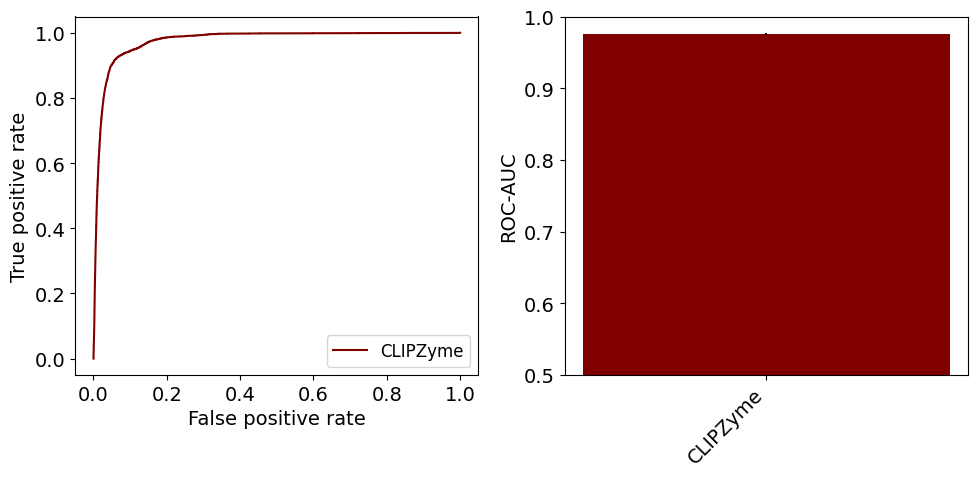

ESM - Negative multiple 10


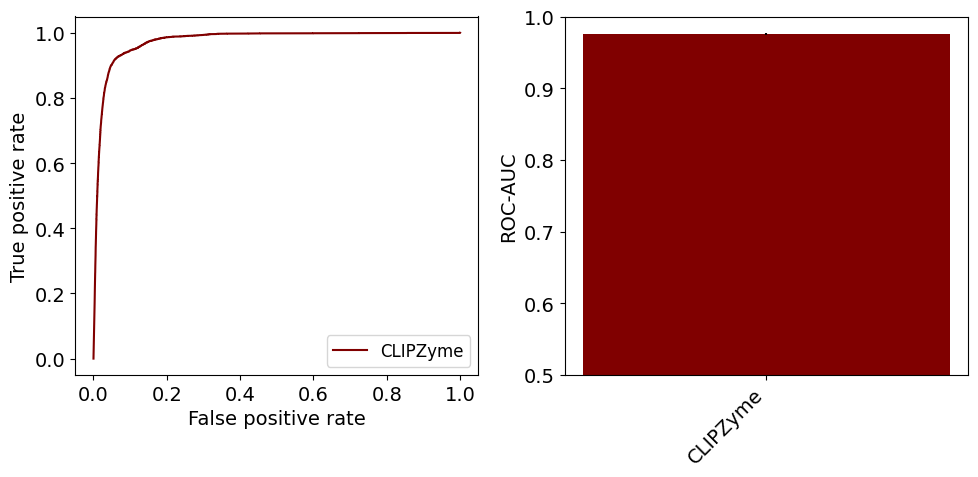

Random reaction - Negative multiple 1


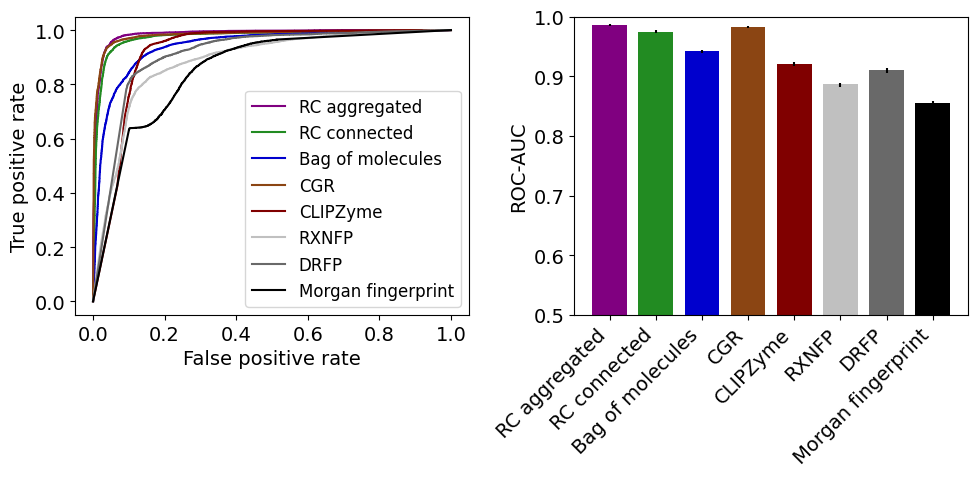

Random reaction - Negative multiple 3


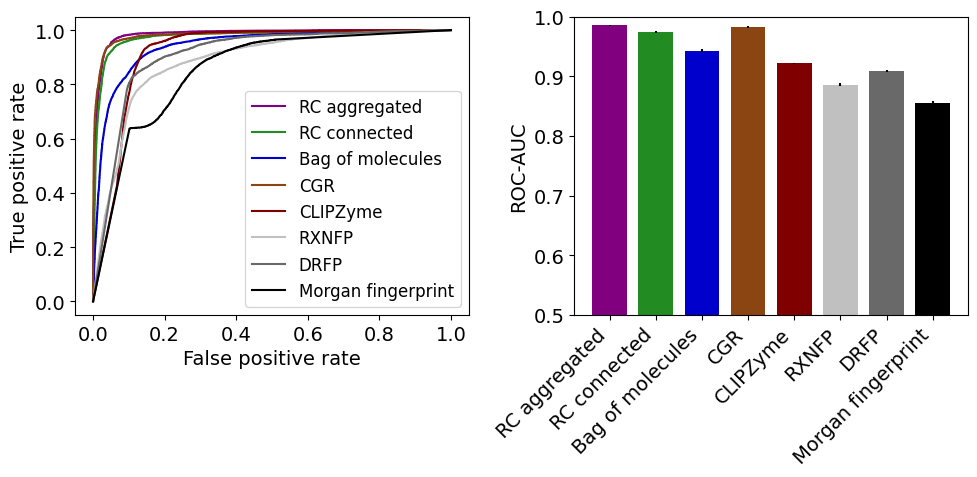

Random reaction - Negative multiple 5


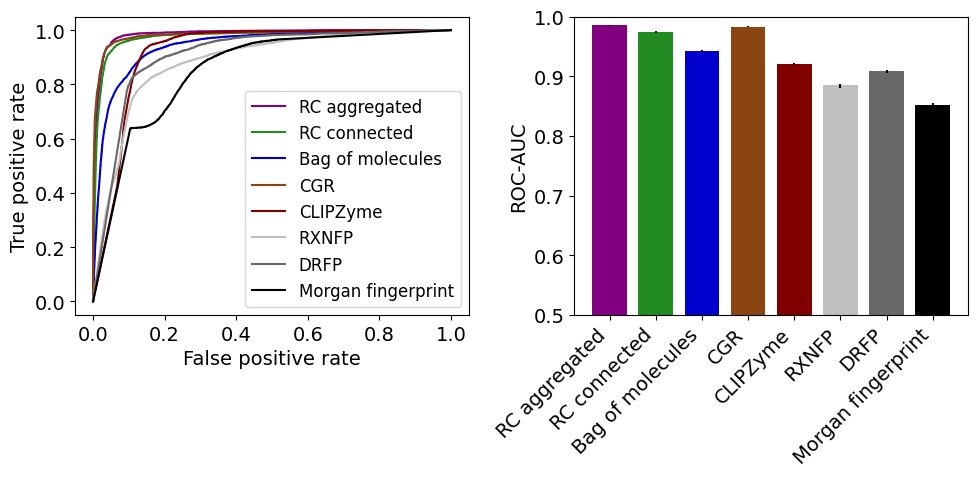

Random reaction - Negative multiple 10


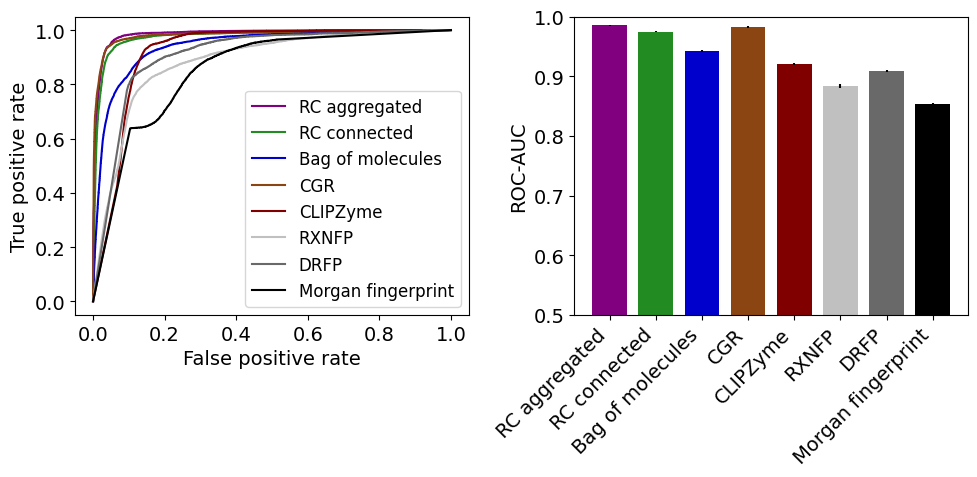

Random reaction center - Negative multiple 1


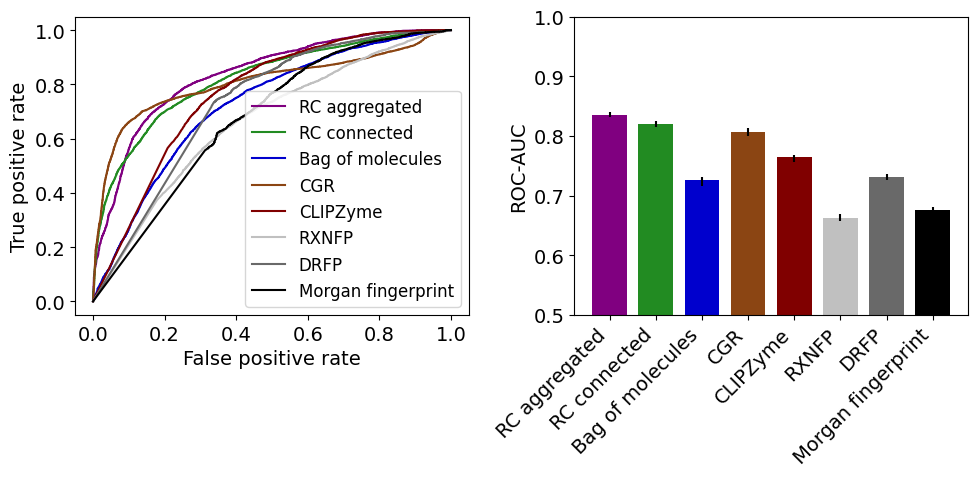

Random reaction center - Negative multiple 3


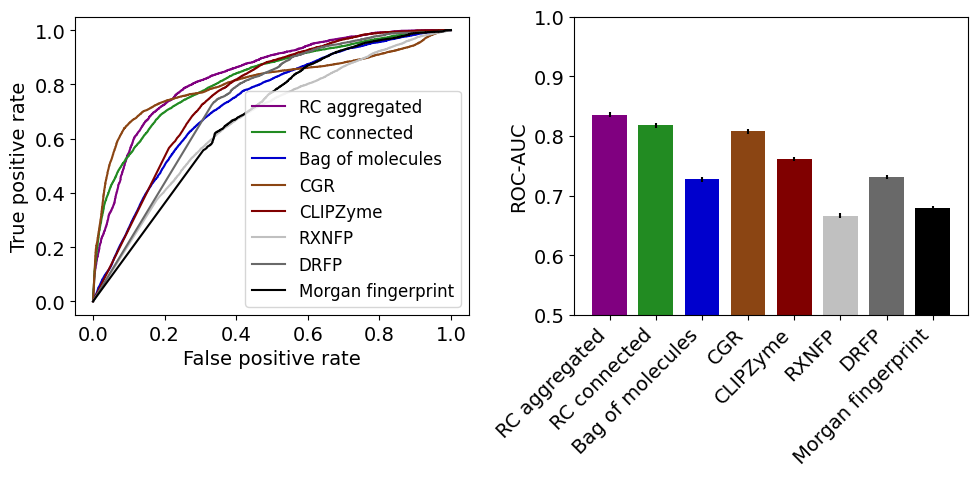

Random reaction center - Negative multiple 5


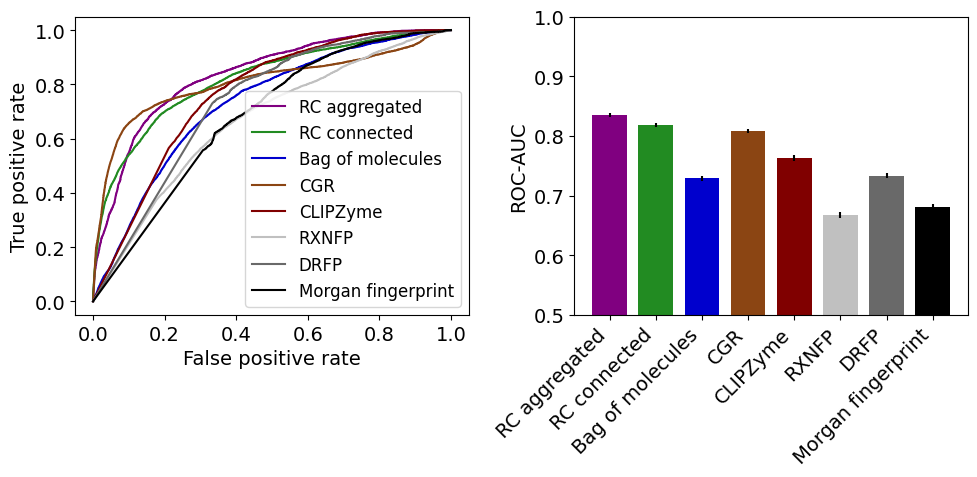

Random reaction center - Negative multiple 10


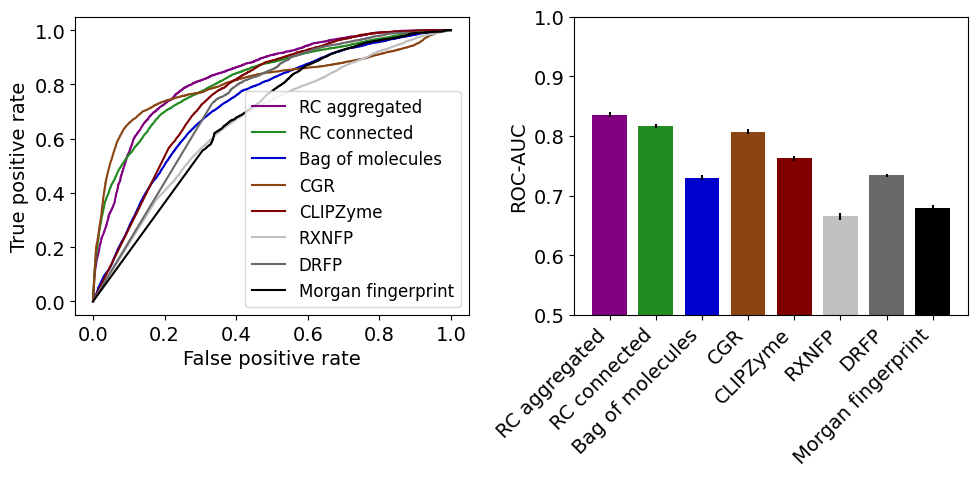

RCMCS - Negative multiple 1


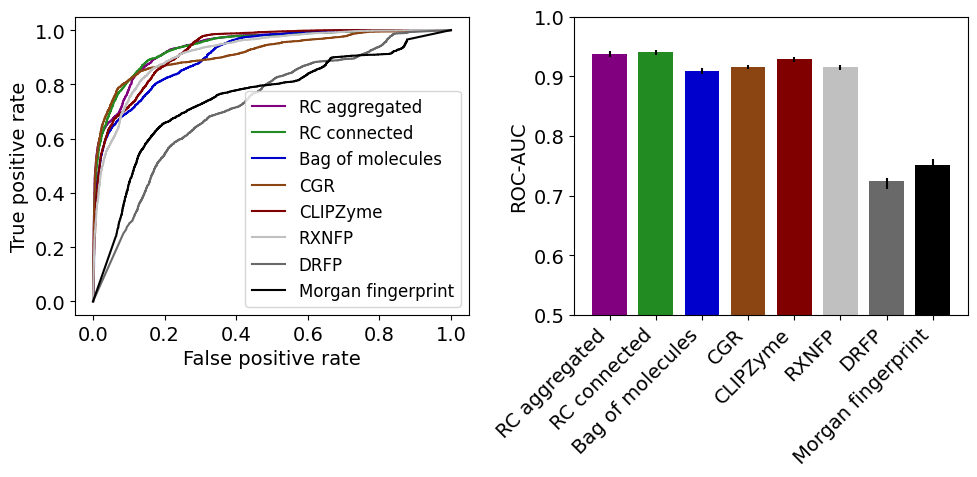

RCMCS - Negative multiple 3


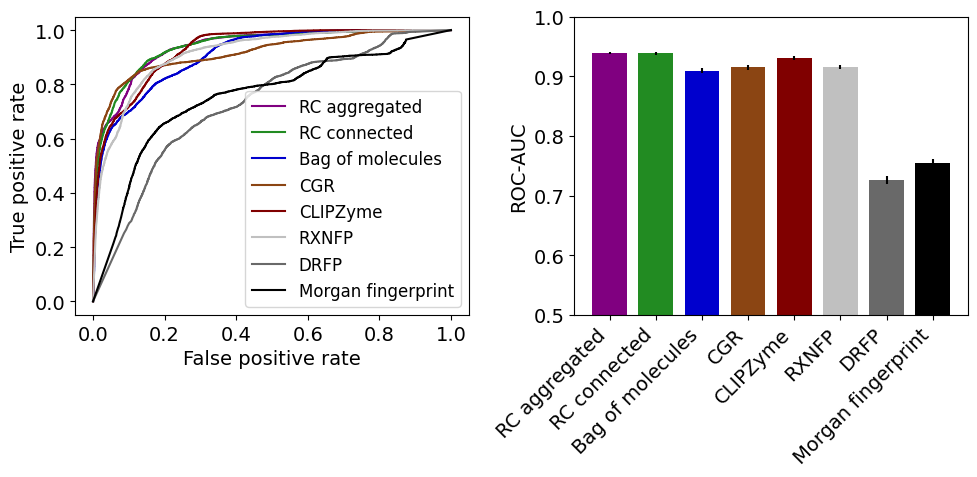

RCMCS - Negative multiple 5


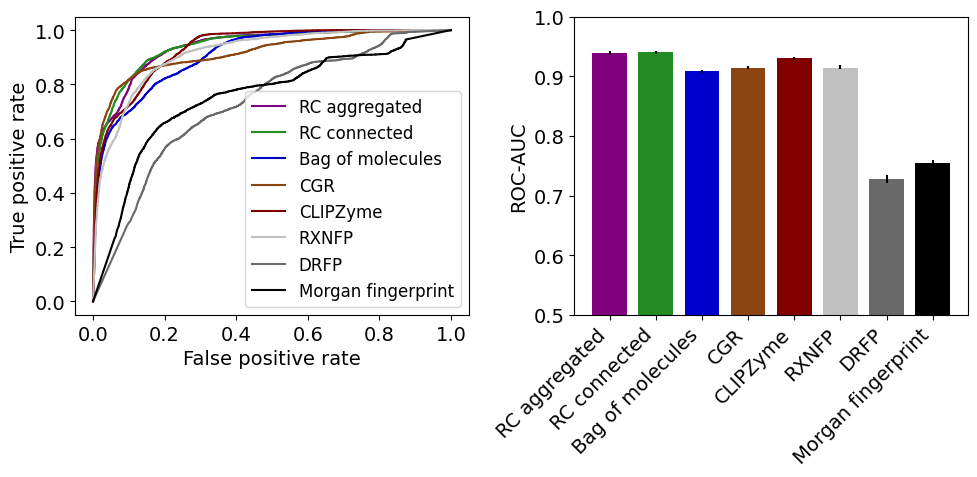

RCMCS - Negative multiple 10


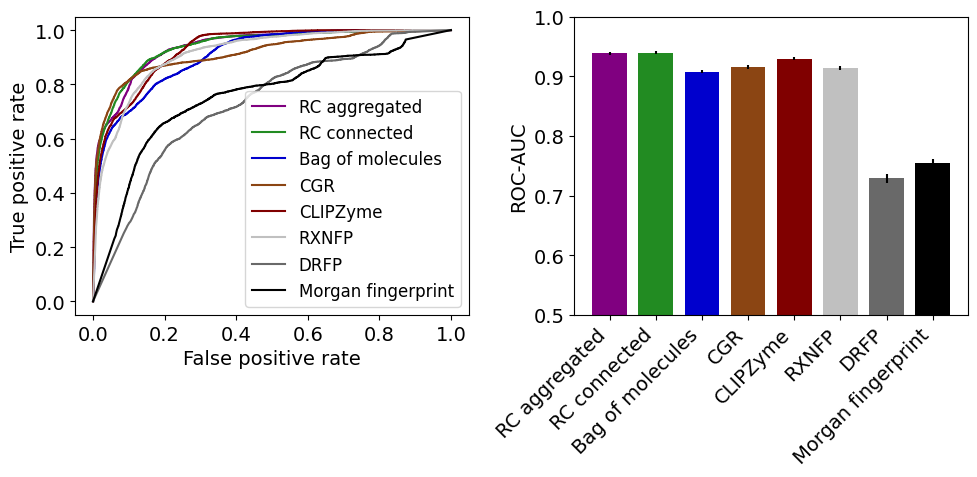

In [16]:
for (strat, nm), df in metrics_table.groupby(['data', 'neg_multiple']):
    roc_fig, roc_axs = plt.subplots(ncols=2, figsize=figsize)
    for _, row in df.drop_duplicates(['id', 'model']).sort_values(by='model', key=get_model_order).iterrows():
        id = row['id']
        model_name = row['model']
        pred = preds[id].loc[nm_keep_indices[id][nm]]
        prec, recall, _ = precision_recall_curve(pred['y'], pred['logits'])
        fpr, tpr, _ = roc_curve(pred['y'], pred['logits'])
        auroc_u, auroc_cil, auroc_ciu = df.loc[
            (df['id'] == id) & (df['model'] == model_name) & (df['metric'] == 'roc_auc'),
            ['mean', 'ci_lower', 'ci_upper']
        ].iloc[0].to_list()
        roc_axs[0].plot(fpr, tpr, color=colors[model_name], label=labels[model_name])

        ci = np.array([auroc_u - auroc_cil, auroc_ciu - auroc_u]).reshape(2, 1)
        roc_axs[1].bar(labels[model_name], height=auroc_u, width=width, yerr=ci, color=colors[model_name])
        
        roc_axs[1].set_ylabel("ROC-AUC")
        roc_axs[1].set_ylim(ylim)
        for label in roc_axs[1].get_xticklabels():
            label.set_rotation(xtick_rot)
            label.set_ha(xtick_ha)
    
    roc_axs[0].set_xlabel("False positive rate")
    roc_axs[0].set_ylabel("True positive rate")
    roc_axs[0].legend()
    print(f"{similarity_names[strat]} - Negative multiple {nm}")
    plt.tight_layout()
    plt.savefig(save_to / "roc" / f"{strat}_nm{nm}_roc.svg")
    plt.show()

Top models inner val metrics with test overlay

In [ ]:
# Bar chart constants

figsize = (15, 5)
width = 0.75  # the width of the bars
xtick_rot = 60
xtick_ha = 'right'
scl_chance = 0.9
chance_color = 'orange'

DRFP - Negative multiple 1


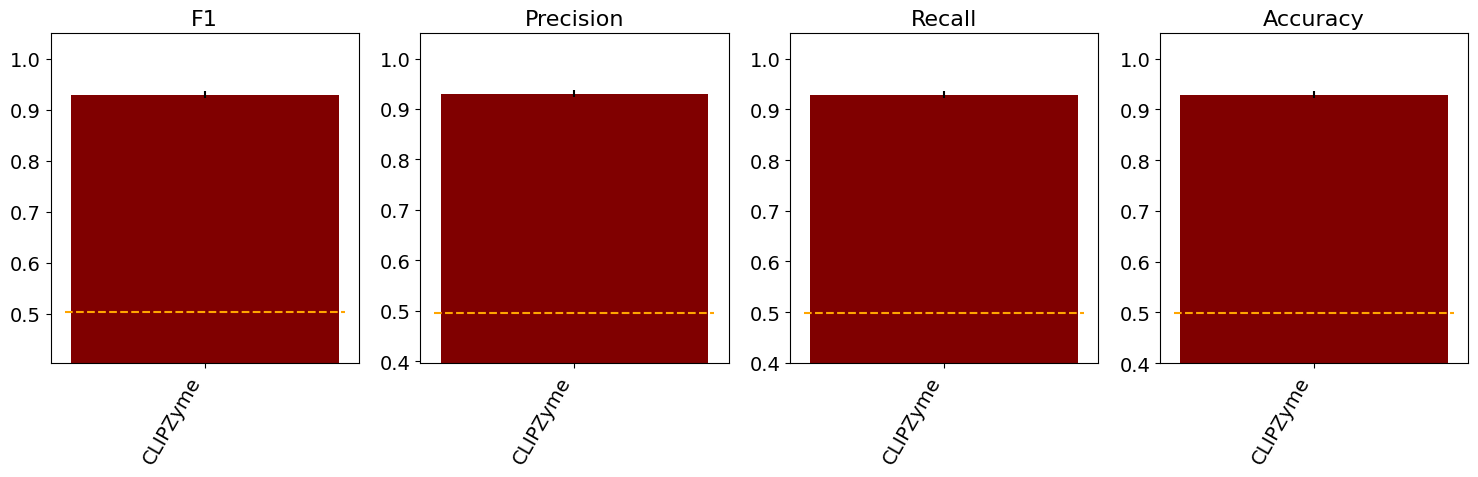

DRFP - Negative multiple 3


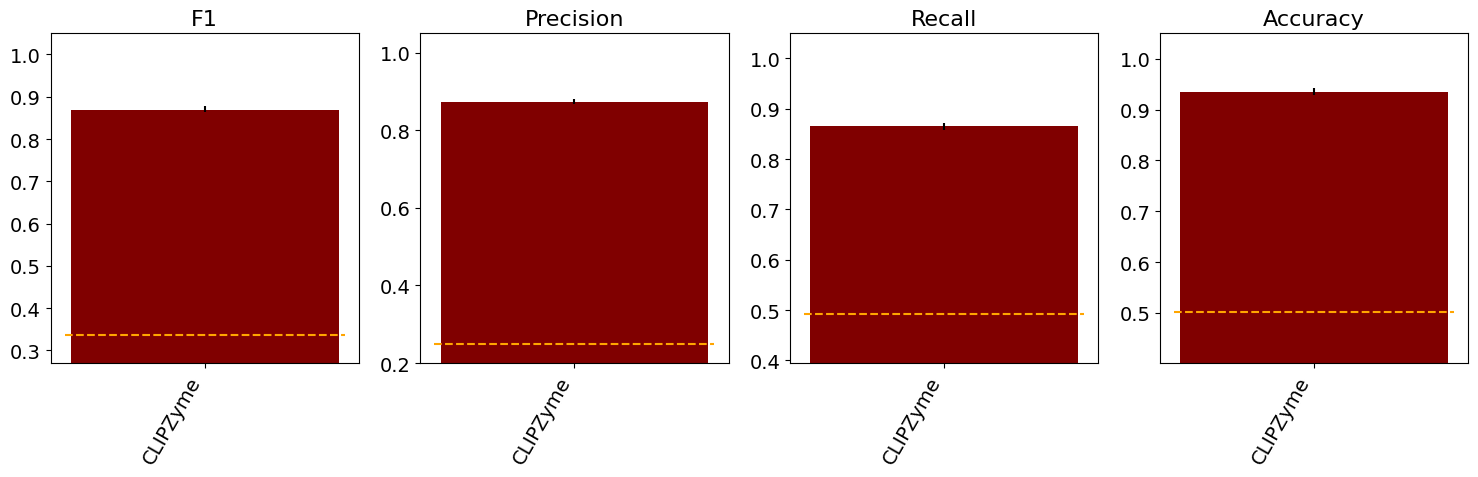

DRFP - Negative multiple 5


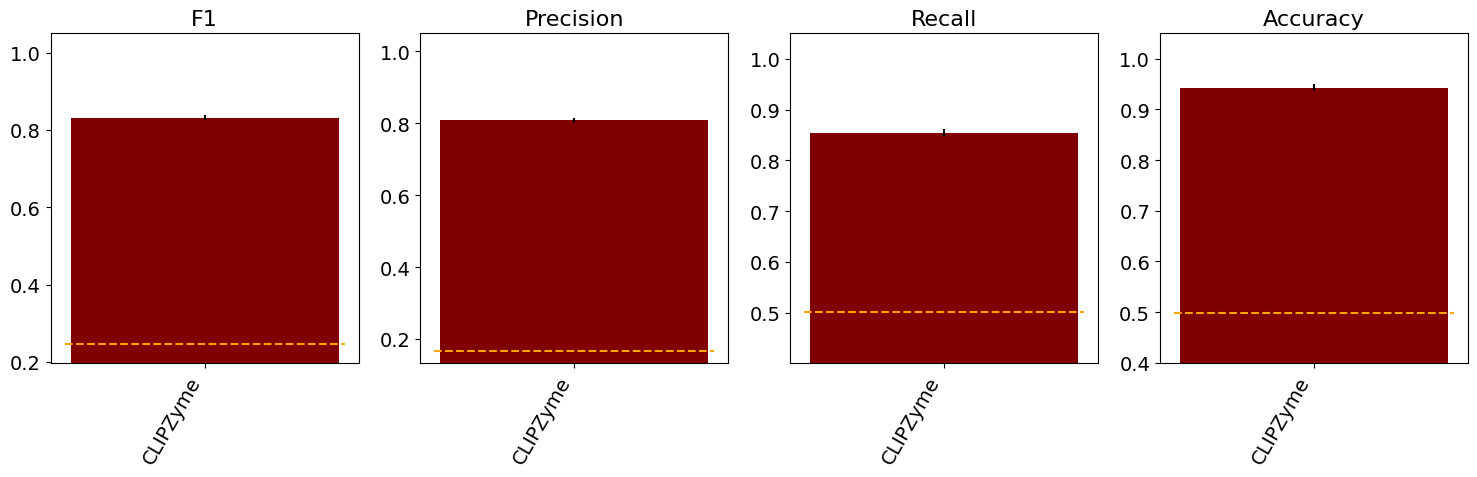

DRFP - Negative multiple 10


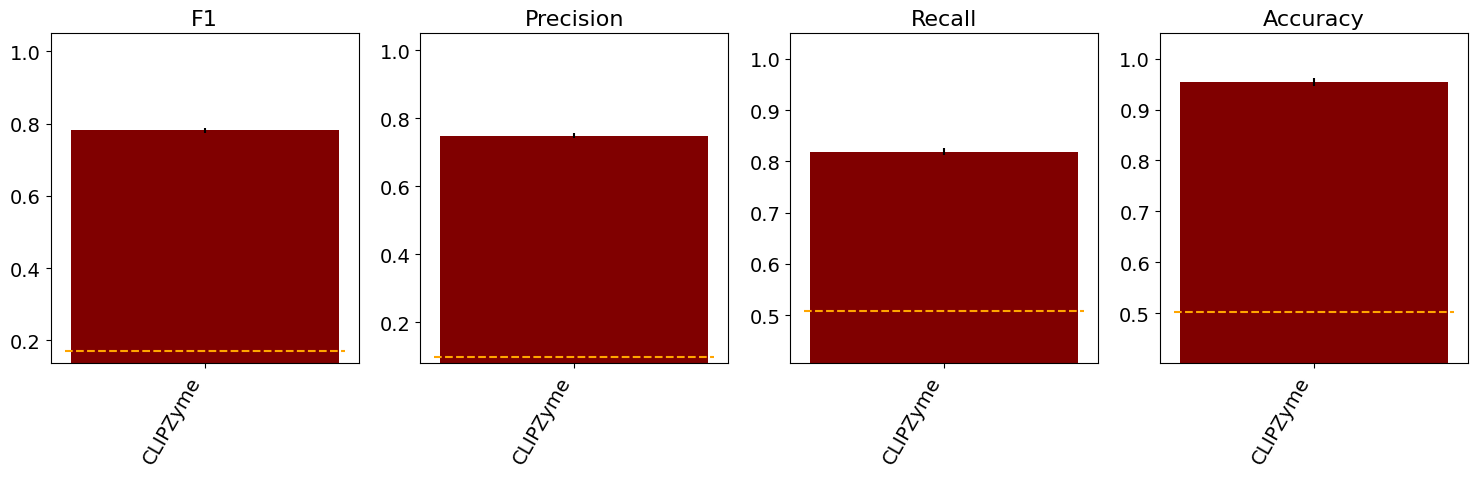

ESM - Negative multiple 1


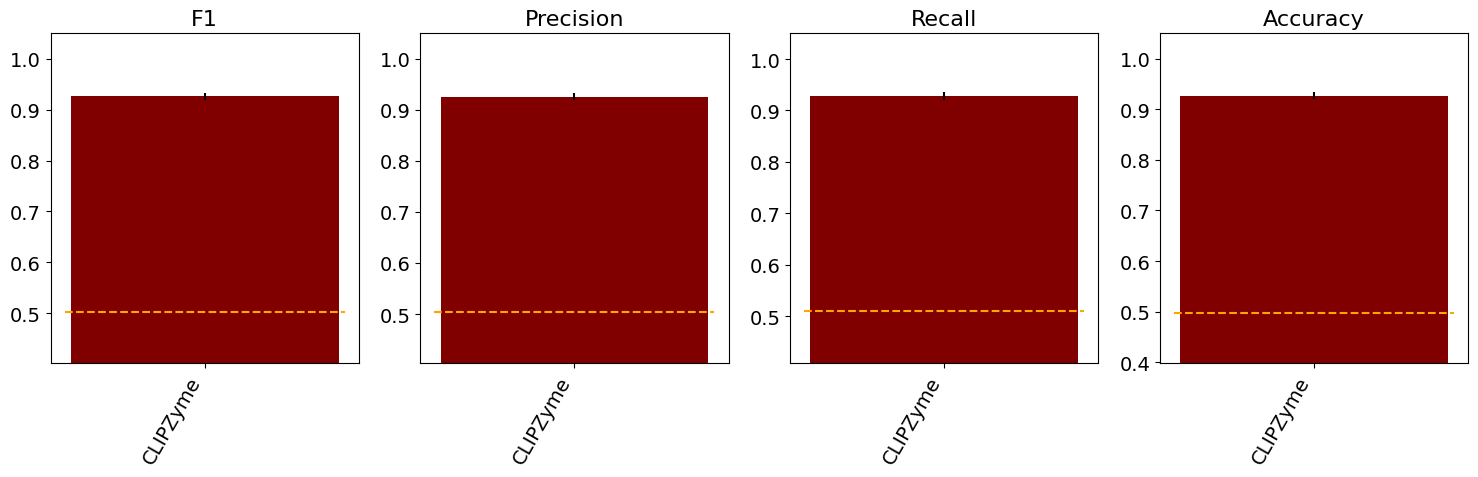

ESM - Negative multiple 3


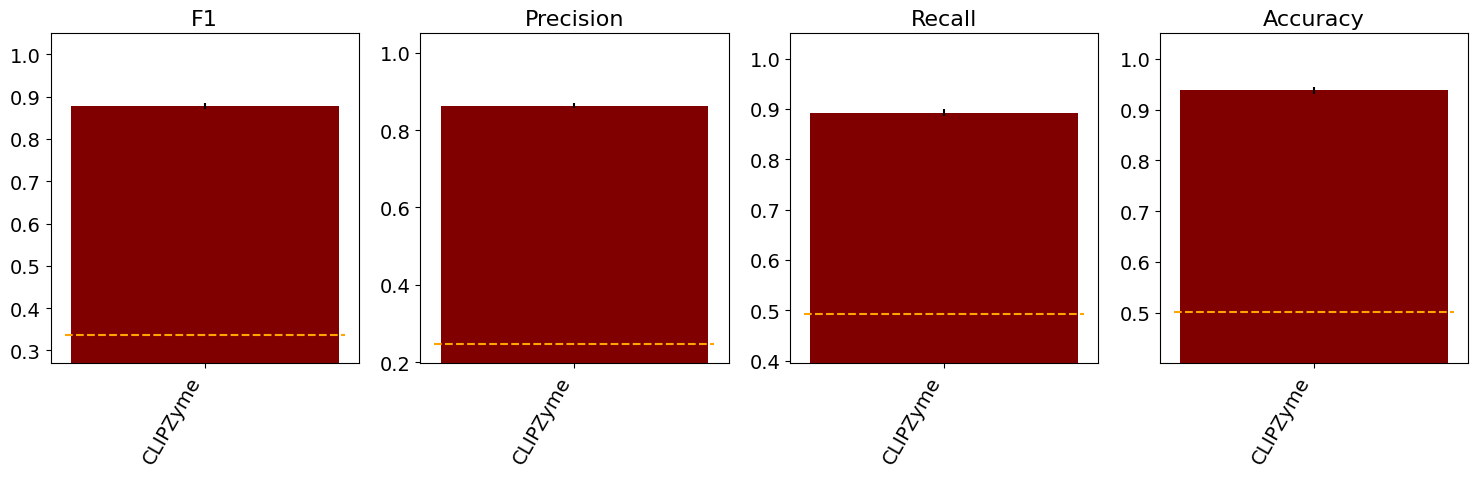

ESM - Negative multiple 5


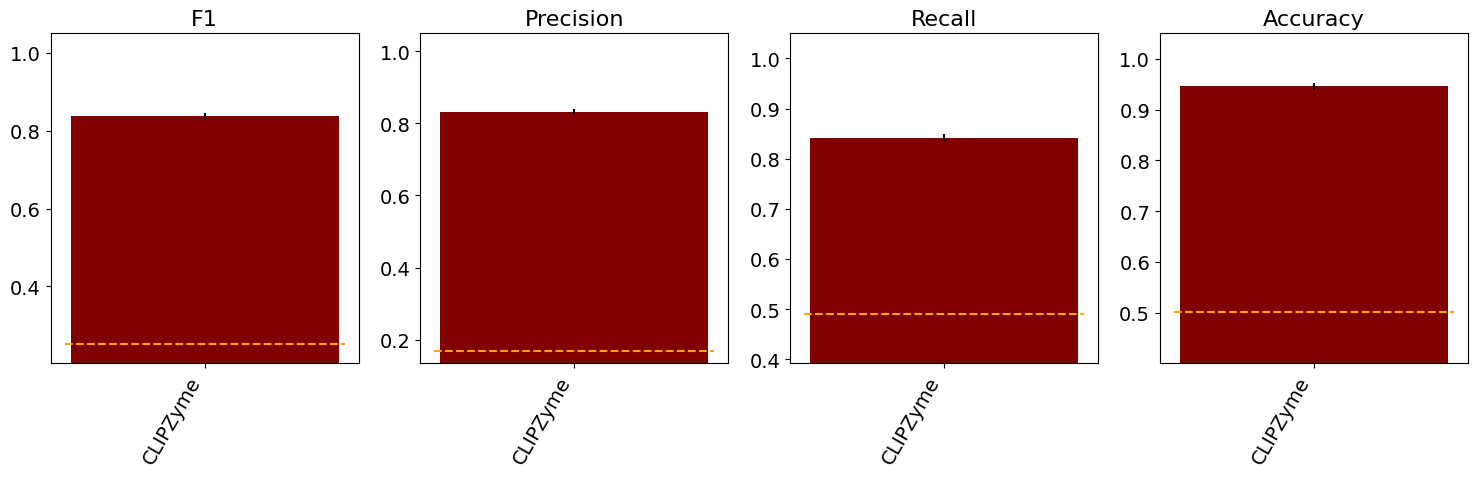

ESM - Negative multiple 10


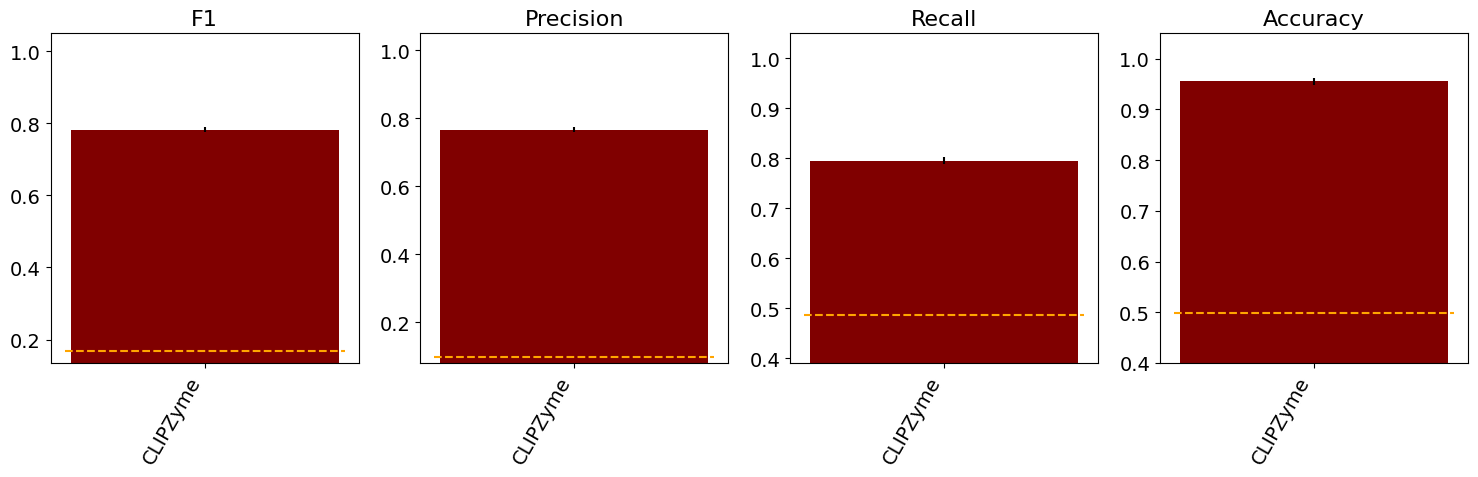

Random reaction - Negative multiple 1


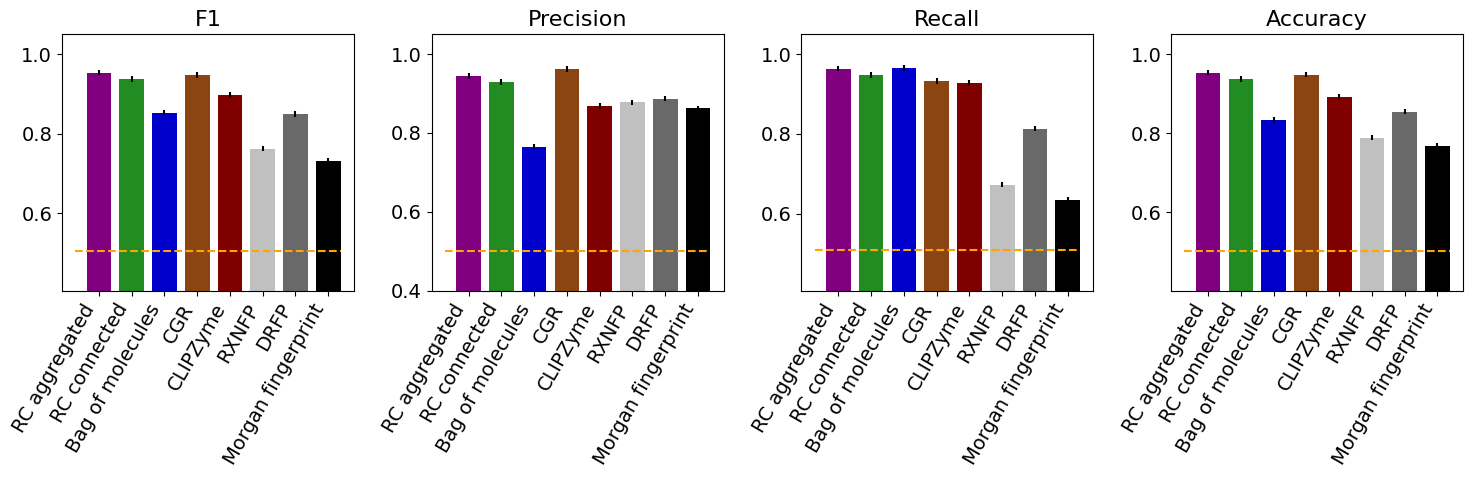

Random reaction - Negative multiple 3


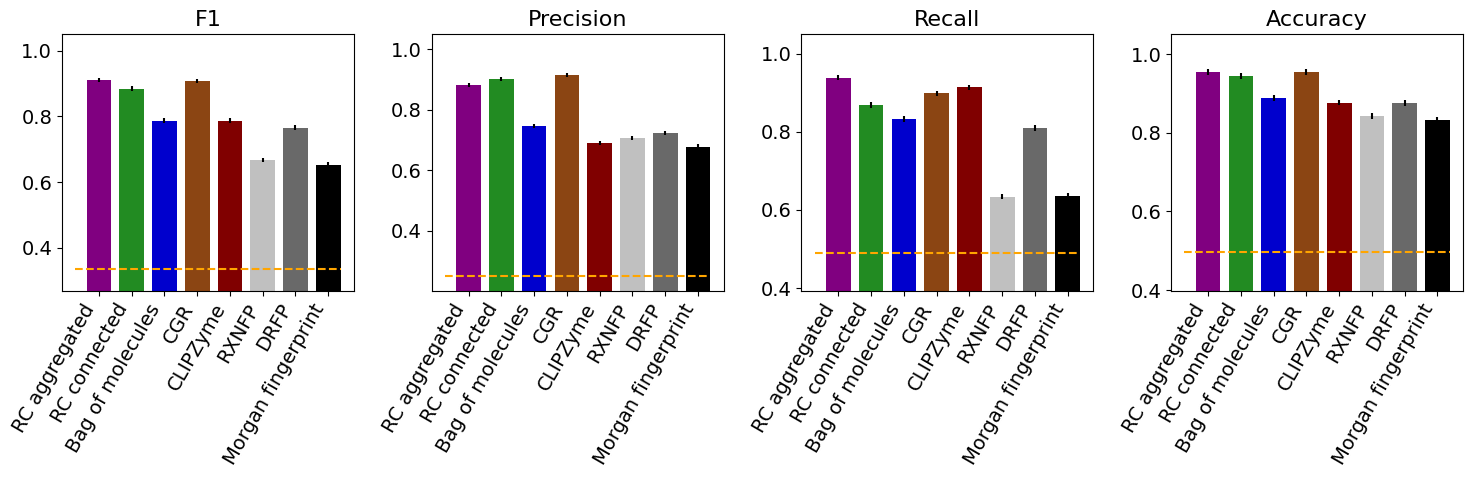

Random reaction - Negative multiple 5


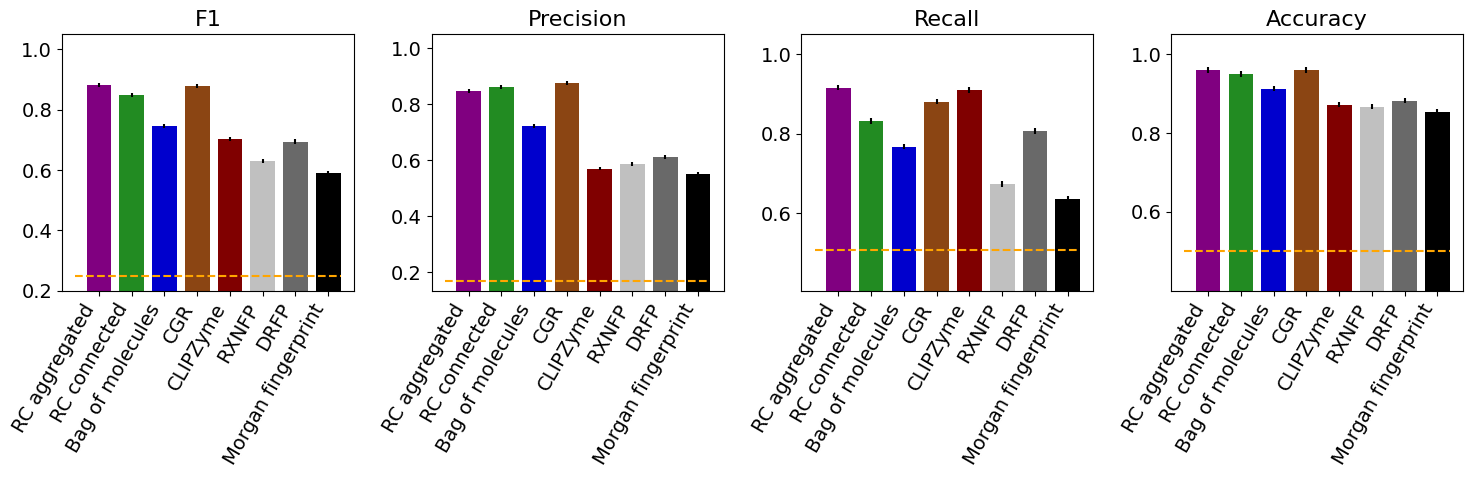

Random reaction - Negative multiple 10


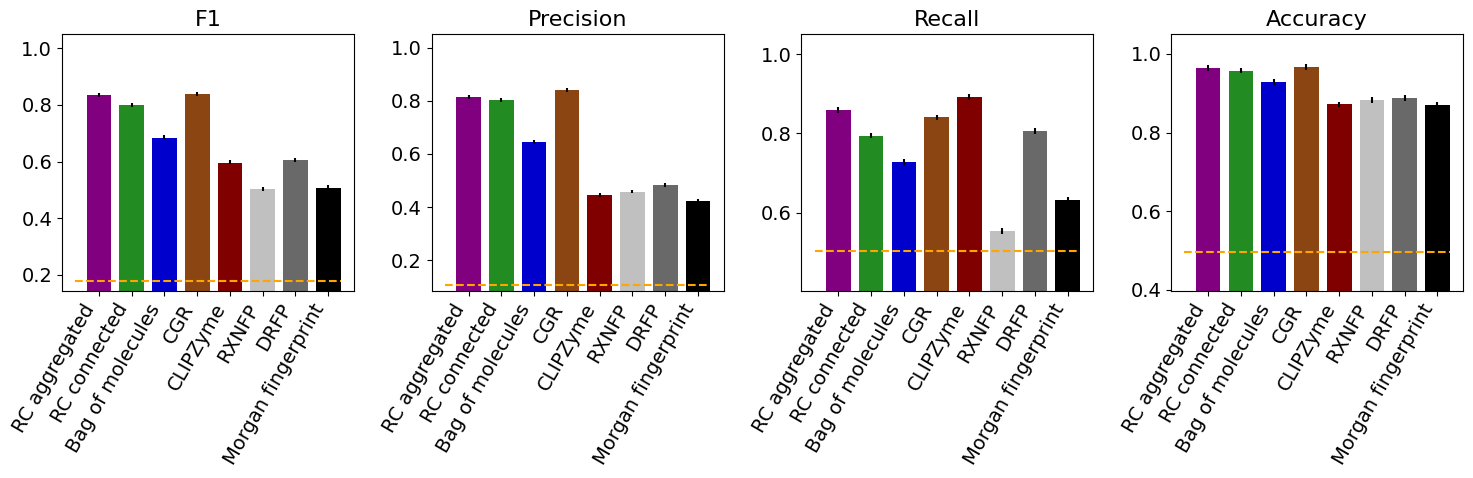

Random reaction center - Negative multiple 1


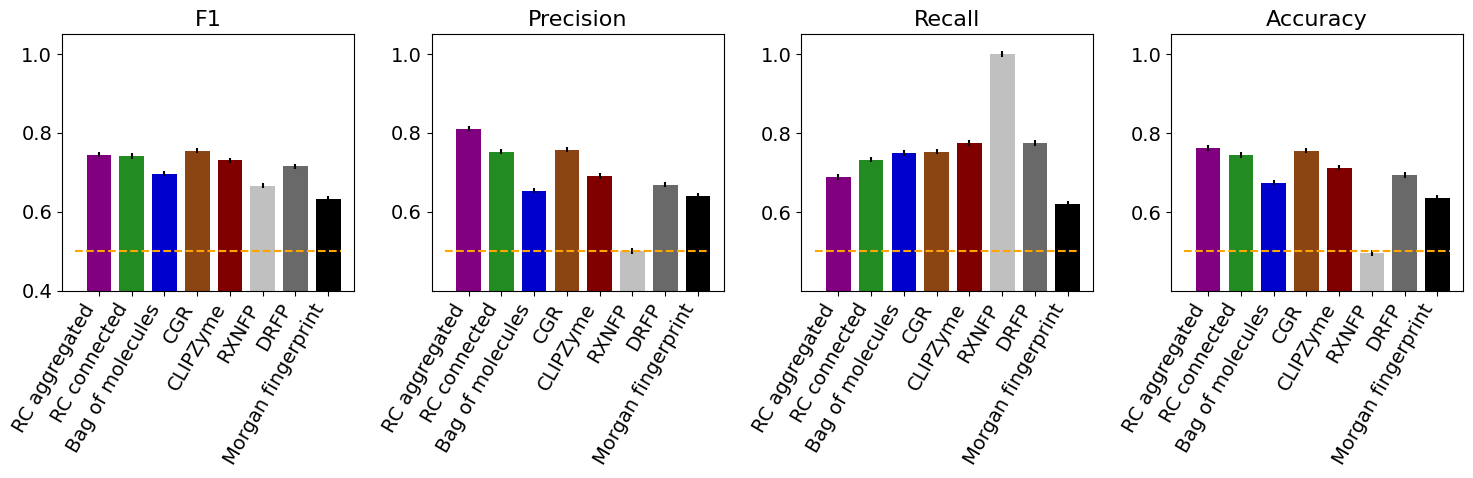

Random reaction center - Negative multiple 3


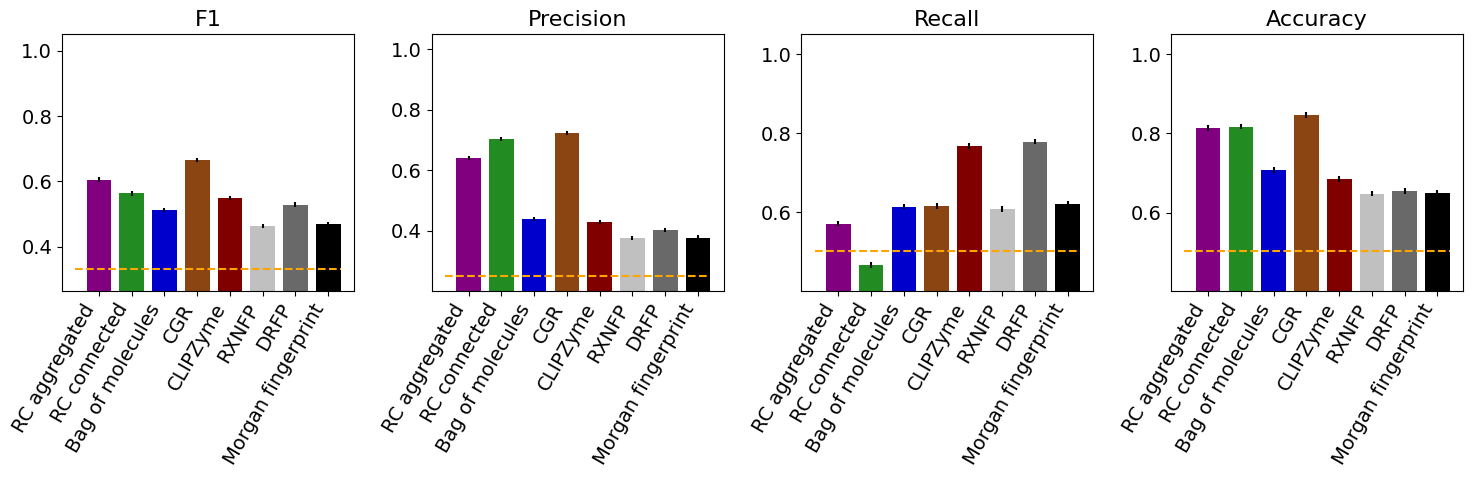

Random reaction center - Negative multiple 5


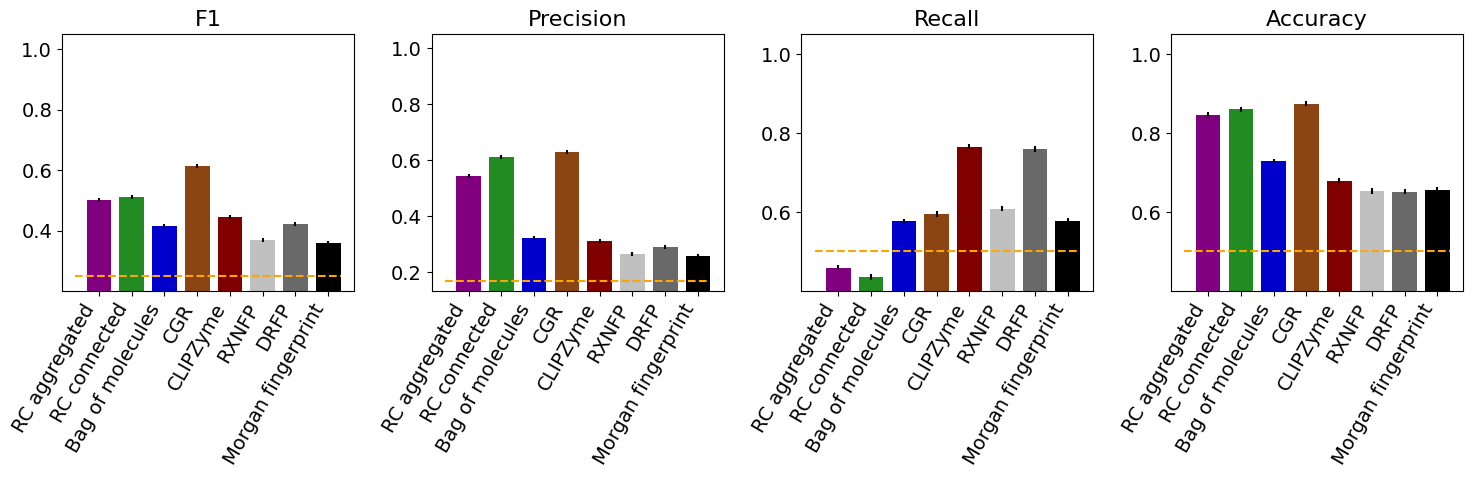

Random reaction center - Negative multiple 10


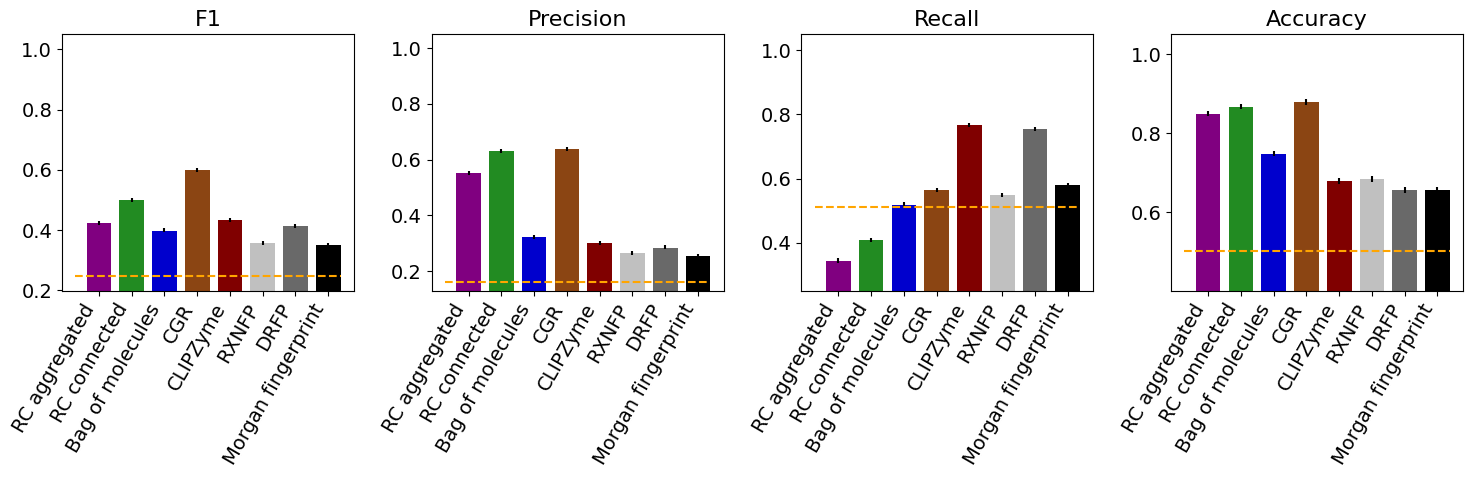

RCMCS - Negative multiple 1


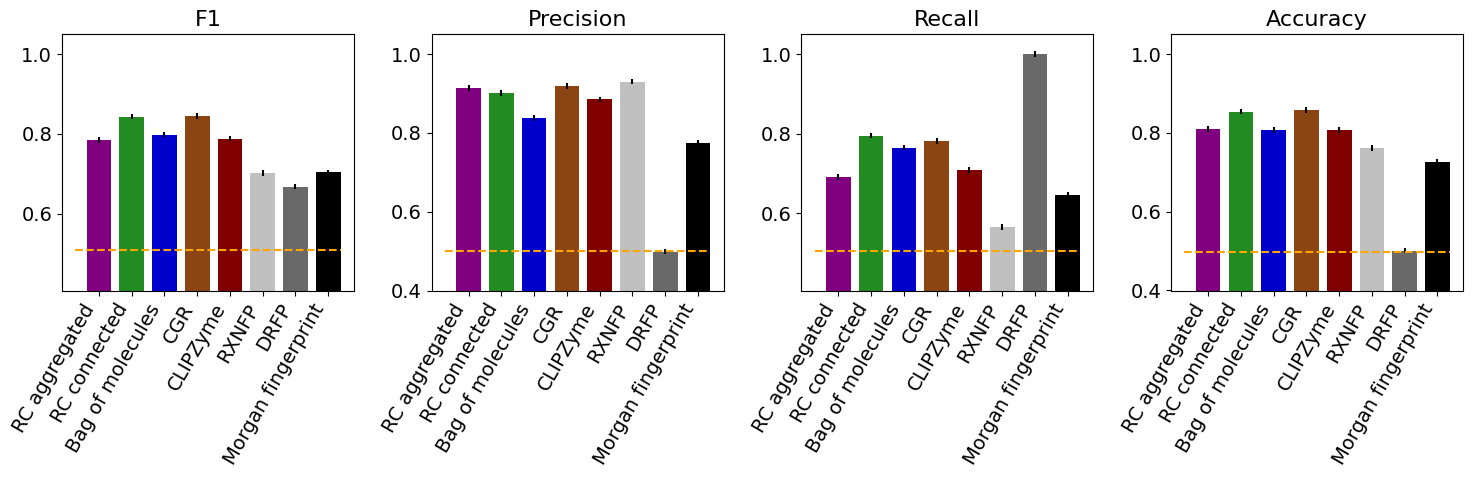

RCMCS - Negative multiple 3


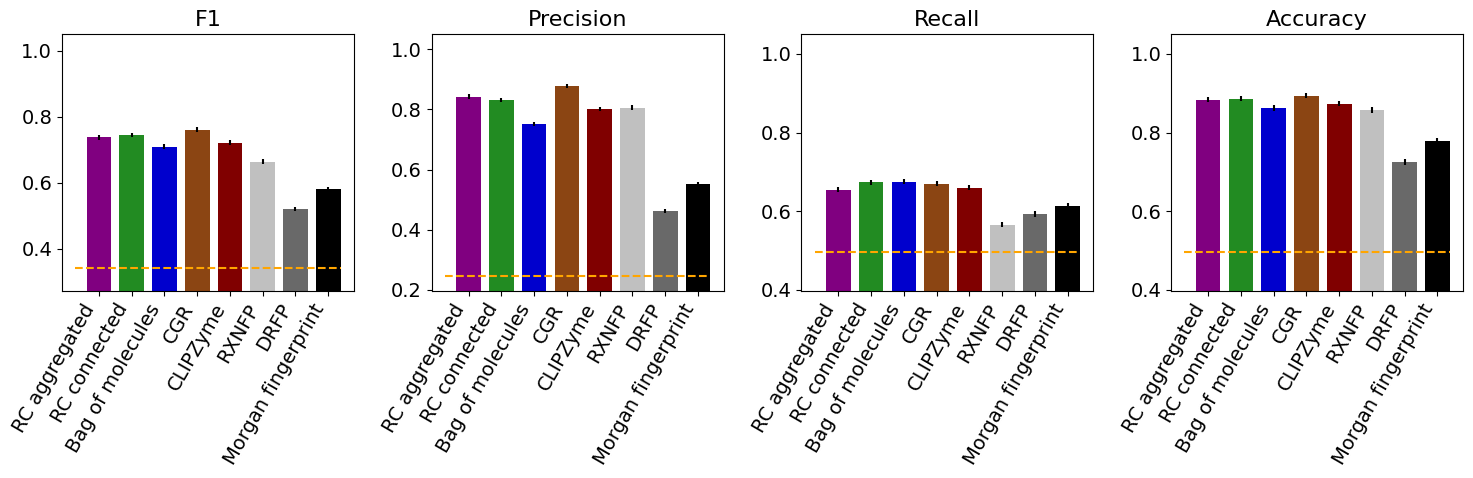

RCMCS - Negative multiple 5


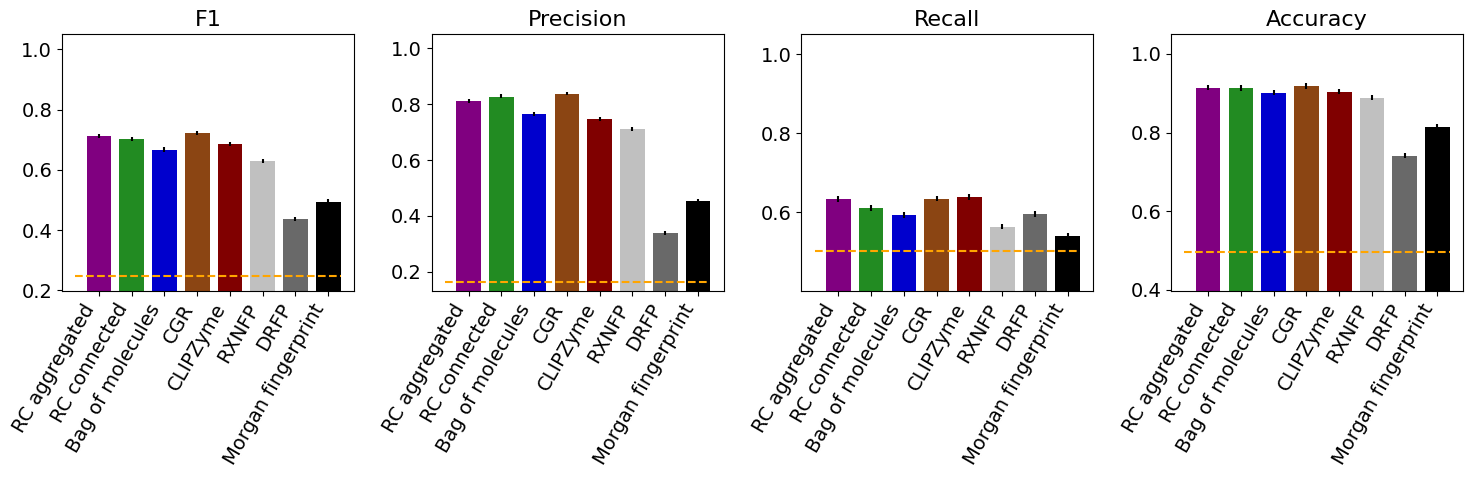

RCMCS - Negative multiple 10


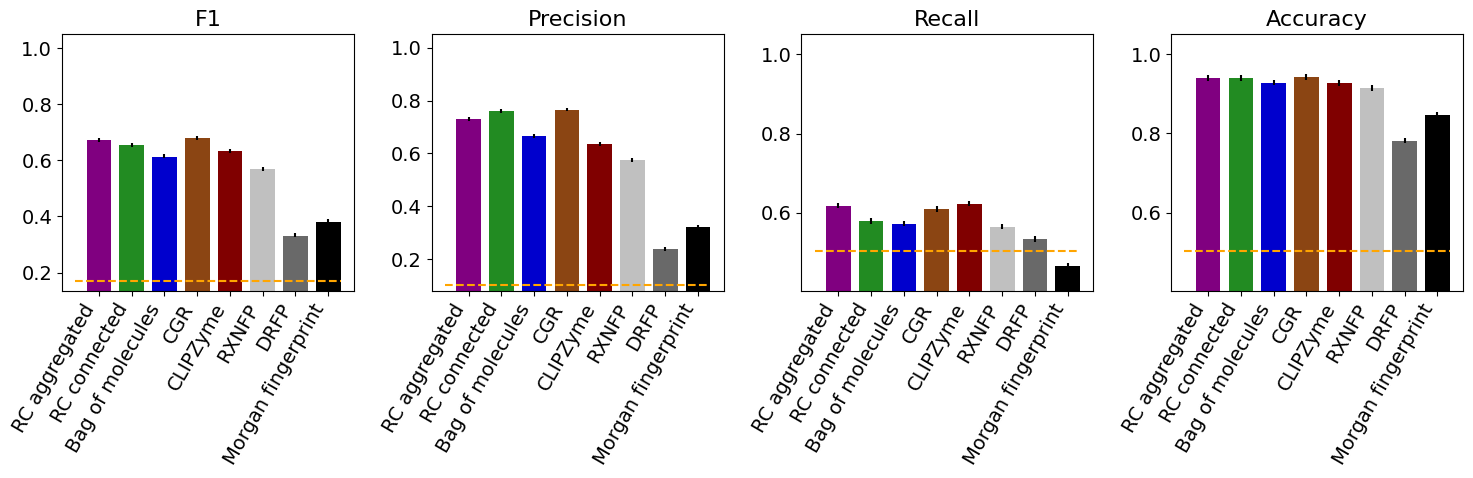

In [33]:
for (strat, nm), df in metrics_table.groupby(['data', 'neg_multiple']):
    fig, ax = plt.subplots(ncols=len(metrics), figsize=figsize, sharey=False)
    for _, row in df.sort_values(by='model', key=get_model_order).iterrows():
        id = row['id']
        model_name = row['model']
        metric_k = row['metric']
        if metric_k not in metrics:
            continue
        i = list(metrics.keys()).index(metric_k)
        
        u, cil, ciu = df.loc[
            (df['id'] == id) & (df['model'] == model_name) & (df['metric'] == metric_k),
            ['mean', 'ci_lower', 'ci_upper']
        ].iloc[0].to_list()
        ci = np.array([auroc_u - auroc_cil, auroc_ciu - auroc_u]).reshape(2, 1)
        ax[i].bar(labels[model_name], height=u, width=width, yerr=ci, color=colors[model_name])
        

        for label in ax[i].get_xticklabels():
            label.set_rotation(xtick_rot)
            label.set_ha(xtick_ha)

    for i in range(len(ax)):
        metric_k = list(metrics.keys())[i]
        ax[i].set_title(metric_names[metric_k])
        _chance = chance[(strat, nm, metric_k)]

        if similarity_names[strat] == "Random reaction center" and nm == 10 and i == 2:
            ax[i].set_ylim(0.25, 1.05)
        else:
            ax[i].set_ylim(scl_chance * _chance, 1.05)

        # Plot horizontal line at chance from min to max x
        x_min, x_max = [0.95 * elt for elt in ax[i].get_xlim()]
        ax[i].hlines(y=_chance, xmin=x_min, xmax=x_max, color=chance_color, linestyle='--')


    print(f"{similarity_names[strat]} - Negative multiple {nm}")
    plt.tight_layout()
    plt.savefig(save_to / "binary_classification" / f"{strat}_nm{nm}_bars.svg")
    plt.show()        

Performance broken down by similarity bucket

In [19]:
# Clustered bar chart constants

sim_split_bins = {
    'rcmcs': [
        (0.8, 1),
        (0.6, 0.8),
        (0.4, 0.6),
        (0.0, 0.4),
    ],
    'homology': [
        (0.7, 1),
        (0.4, 0.7),
        (0.3, 0.4),
        (0.0, 0.3),
    ],
    'drfp': [
        (0.6, 1),
        (0.4, 0.6),
        (0.2, 0.4),
        (0.0, 0.2),
    ],
    'esm': [
        (0.98, 1),
        (0.97, 0.98),
    ]

}

In [20]:
split_metrics_table = []
cols = ['data', 'model', 'neg_multiple', 'sim_split', 'metric', 'mean', 'ci_lower', 'ci_upper', 'id']
for strat, bins in sim_split_bins.items():
    for runid, name in id2name.items():
        if name['data'] != strat:
            continue
        model_name = name['model']
        for nm in nm_keep_indices[runid].keys():
            _target_output = preds[runid].loc[nm_keep_indices[runid][nm]]
            for i, (lb, ub) in enumerate(sim_split_bins[strat]):
                _bin_df = _target_output.loc[(_target_output['max_sim'] >= lb) & (_target_output['max_sim'] < ub)]
                if len(_bin_df) == 0:
                    continue
                for metric_k, metric in discrete_metrics.items():
                    mean, (ci_l, ci_u) = metric(_bin_df['y'].to_numpy(), _bin_df['logits'].to_numpy(), threshold=best_thresholds[runid][nm])
                    split_metrics_table.append(
                        [
                            strat,
                            model_name,
                            nm,
                            (lb, ub),
                            metric_k,
                            mean,
                            ci_l,
                            ci_u,
                            runid
                        ]
                    )
                for metric_k, metric in continuous_metrics.items():
                    mean, (ci_l, ci_u) = metric(_bin_df['y'].to_numpy(), _bin_df['logits'].to_numpy())
                    split_metrics_table.append(
                        [
                            strat,
                            model_name,
                            nm,
                            (lb, ub),
                            metric_k,
                            mean,
                            ci_l,
                            ci_u,
                            runid
                        ]
                    )
split_metrics_table = pd.DataFrame(split_metrics_table, columns=cols)
split_metrics_table.head()

data  model  neg_multiple sim_split            metric      mean  ci_lower  \
0  rcmcs  rxnfp             1  (0.8, 1)                f1  0.875450  0.857010   
1  rcmcs  rxnfp             1  (0.8, 1)  binary_precision  0.948758  0.933484   
2  rcmcs  rxnfp             1  (0.8, 1)     binary_recall  0.820071  0.799249   
3  rcmcs  rxnfp             1  (0.8, 1)          accuracy  0.899459  0.890936   
4  rcmcs  rxnfp             1  (0.8, 1)           roc_auc  0.957539  0.946474   

   ci_upper                                id  
0  0.888438  bafce811361c4d19afe7919fb4666fb2  
1  0.957765  bafce811361c4d19afe7919fb4666fb2  
2  0.839918  bafce811361c4d19afe7919fb4666fb2  
3  0.907658  bafce811361c4d19afe7919fb4666fb2  
4  0.962626  bafce811361c4d19afe7919fb4666fb2

In [21]:
bins2labels = lambda bins: [f"[{b[0]}, {b[1]})" for b in bins]

bar_shifts = {k: i for i, k in enumerate(labels.keys())}

width = 0.12
space = 1.05
figsize = (15, 4)
metrics_of_i = [
    'f1',
    'roc_auc',
    # 'accuracy'
]

drfp 1


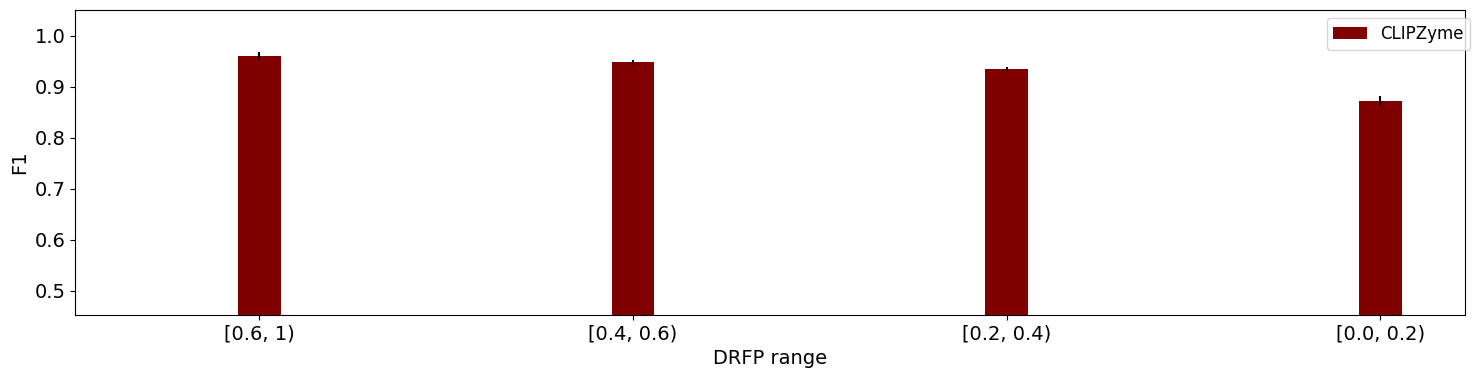

drfp 3


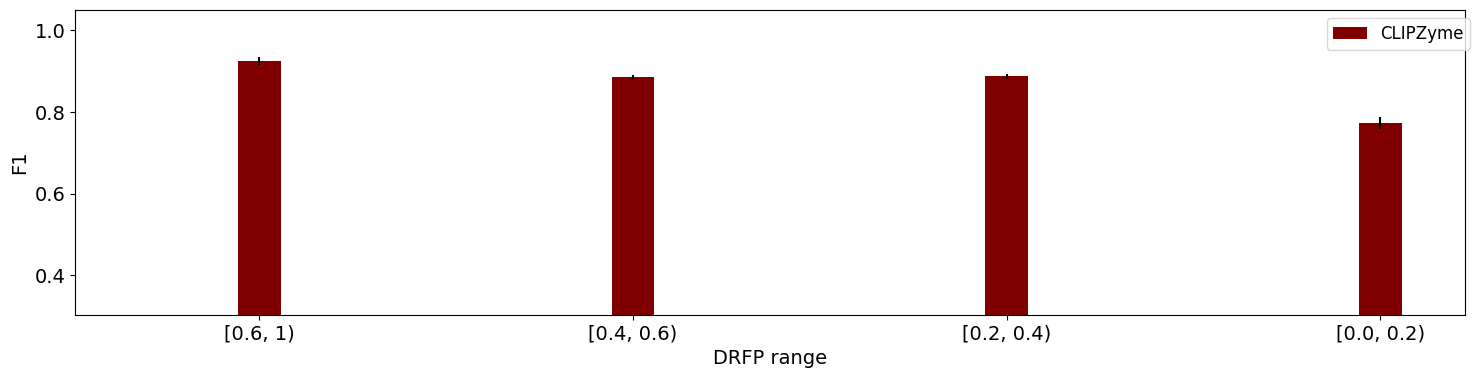

drfp 5


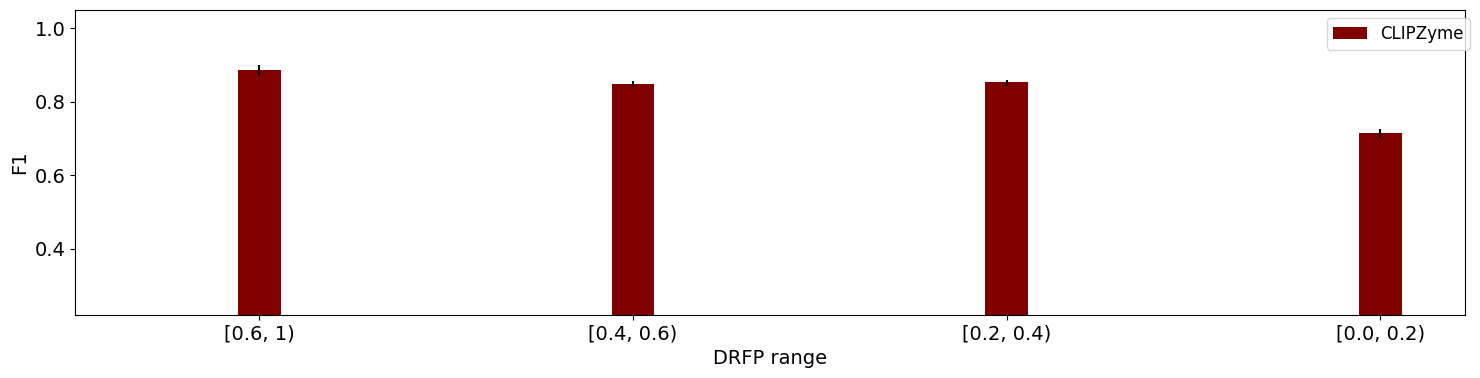

drfp 10


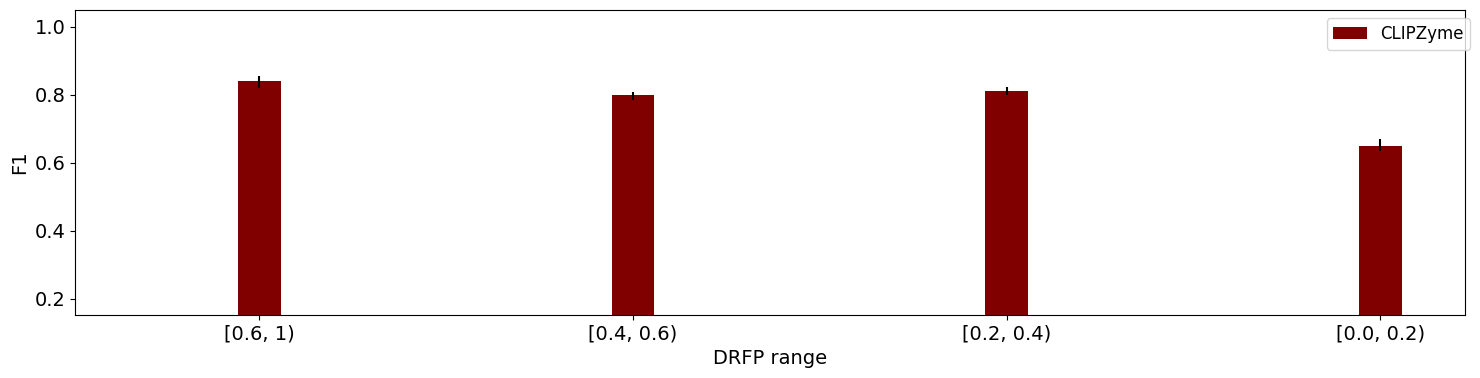

drfp 1


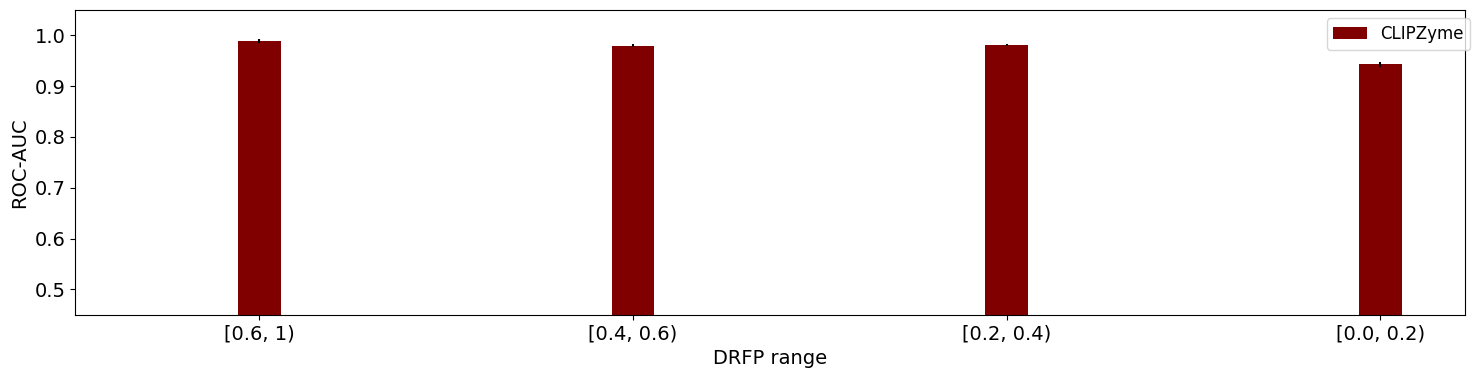

drfp 3


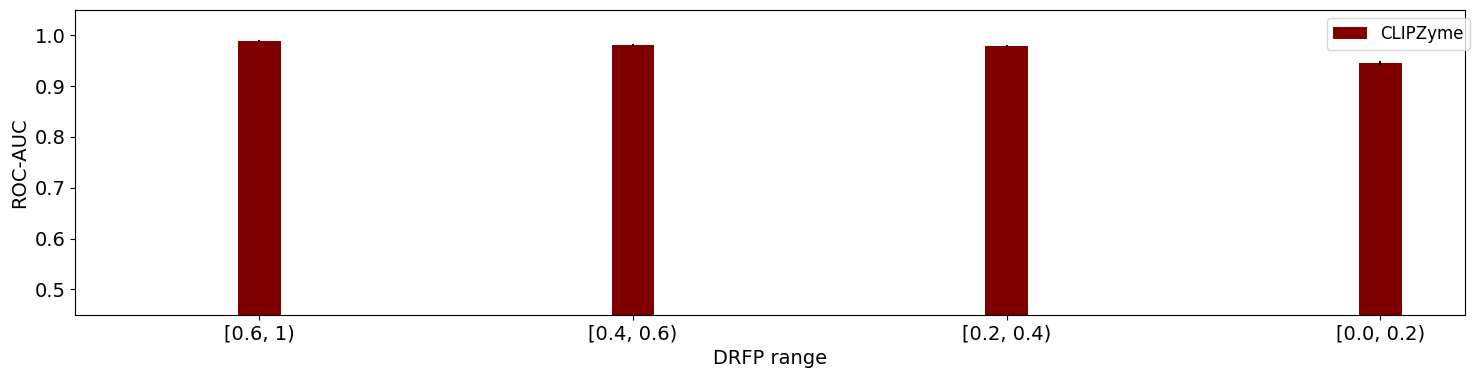

drfp 5


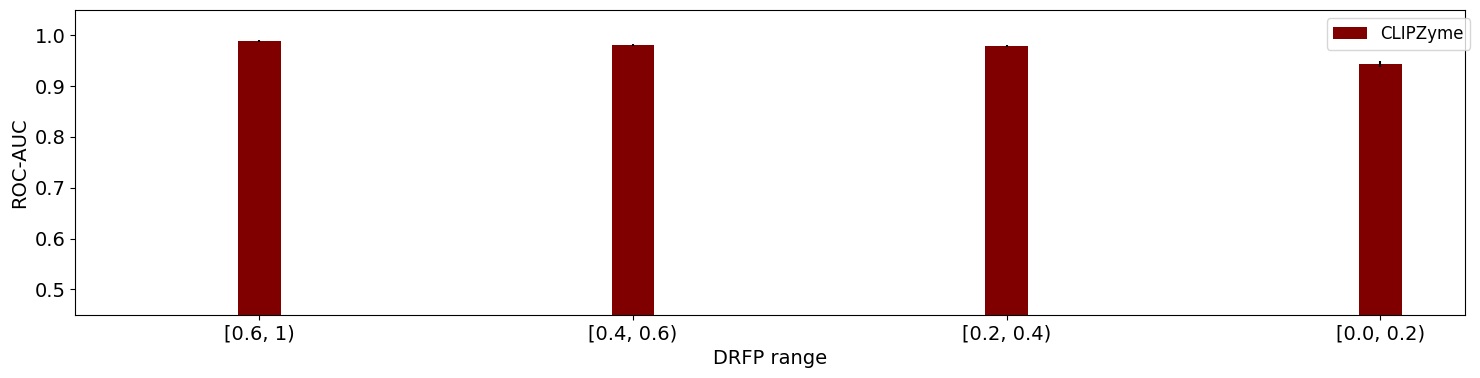

drfp 10


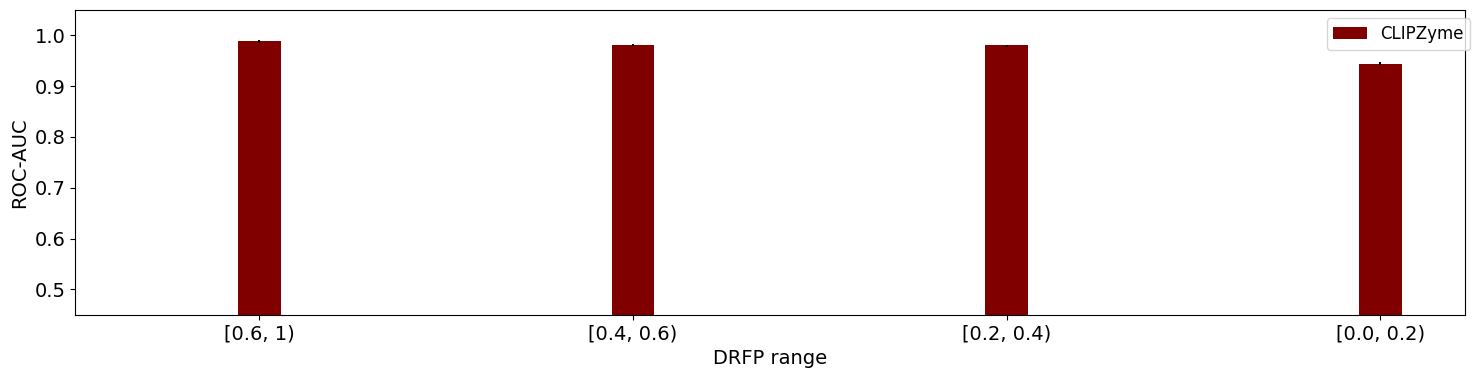

esm 1


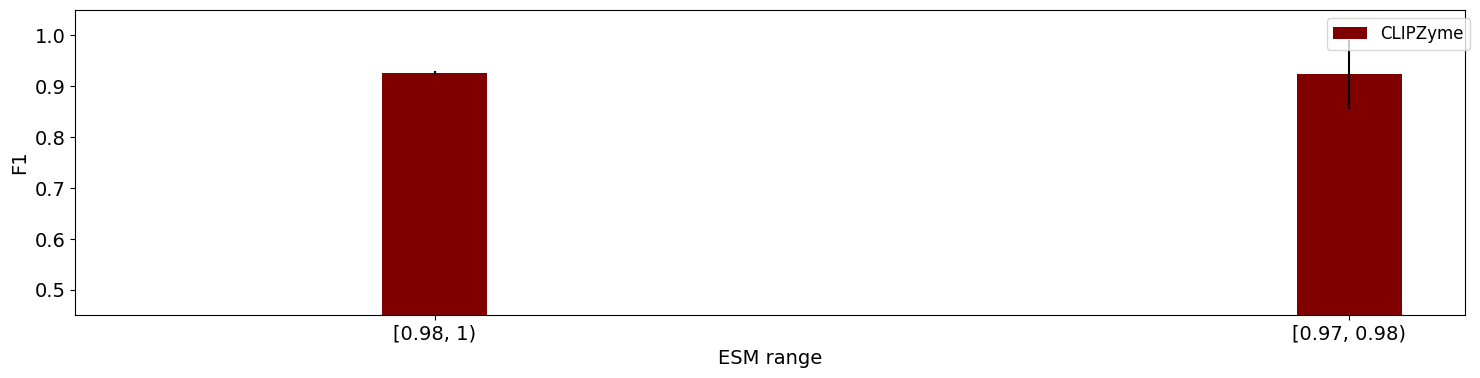

esm 3


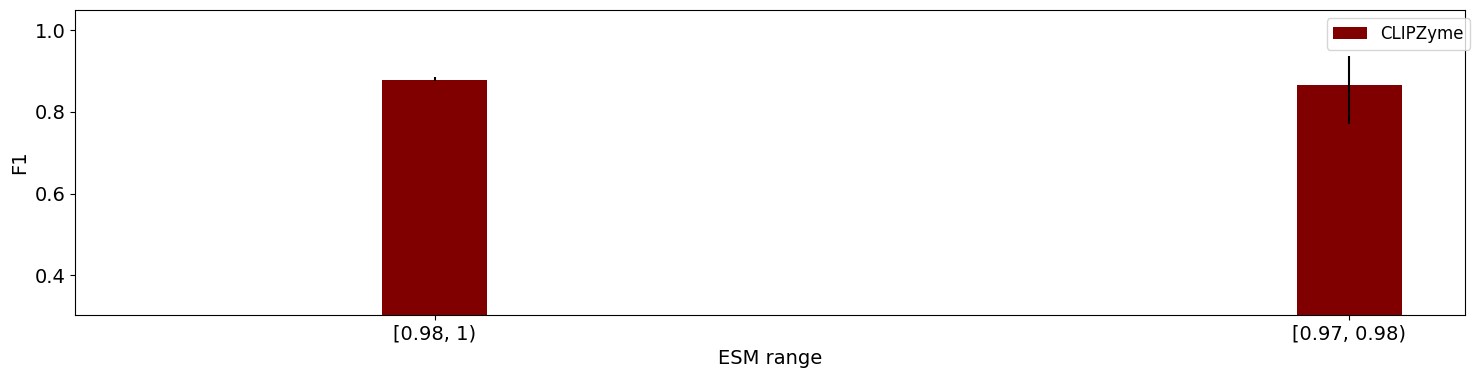

esm 5


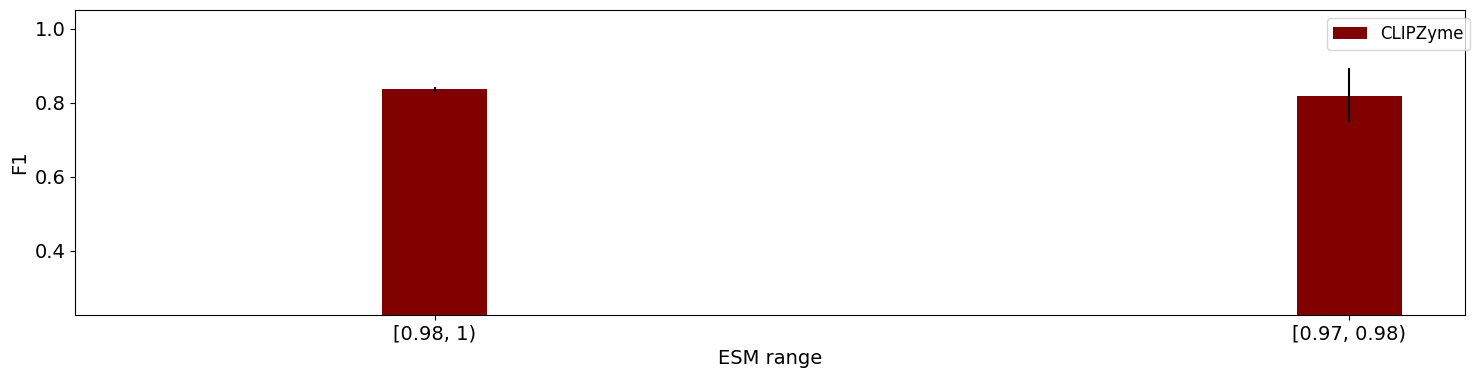

esm 10


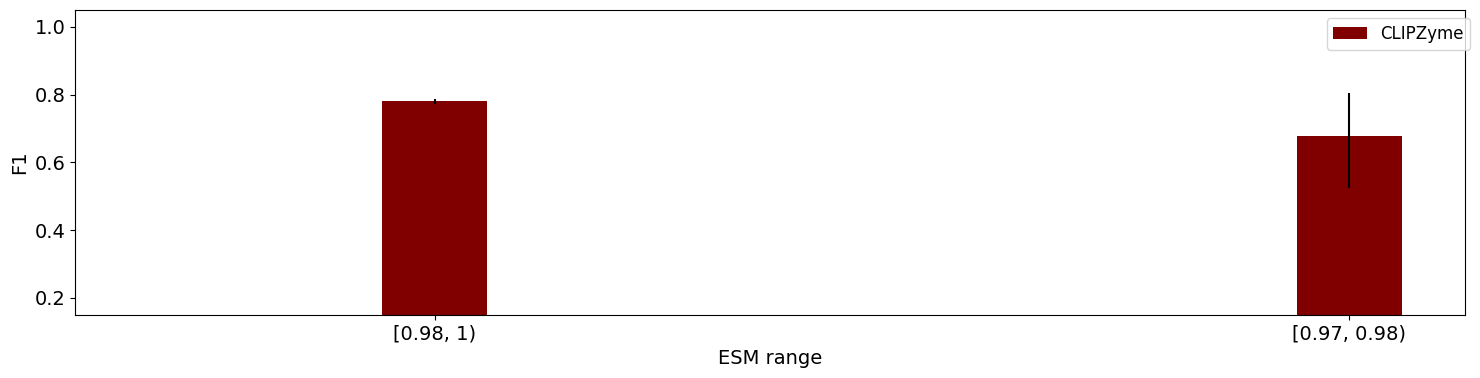

esm 1


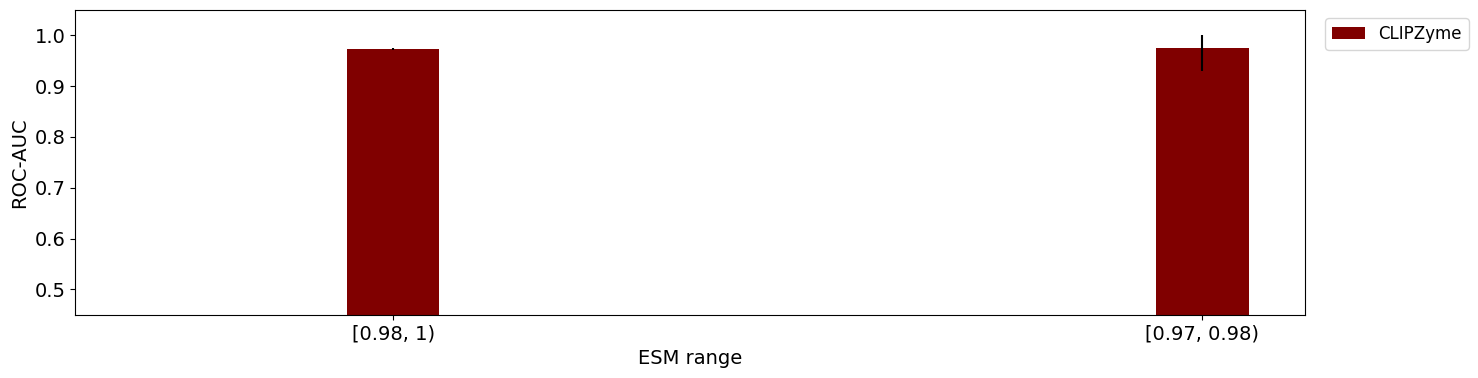

esm 3


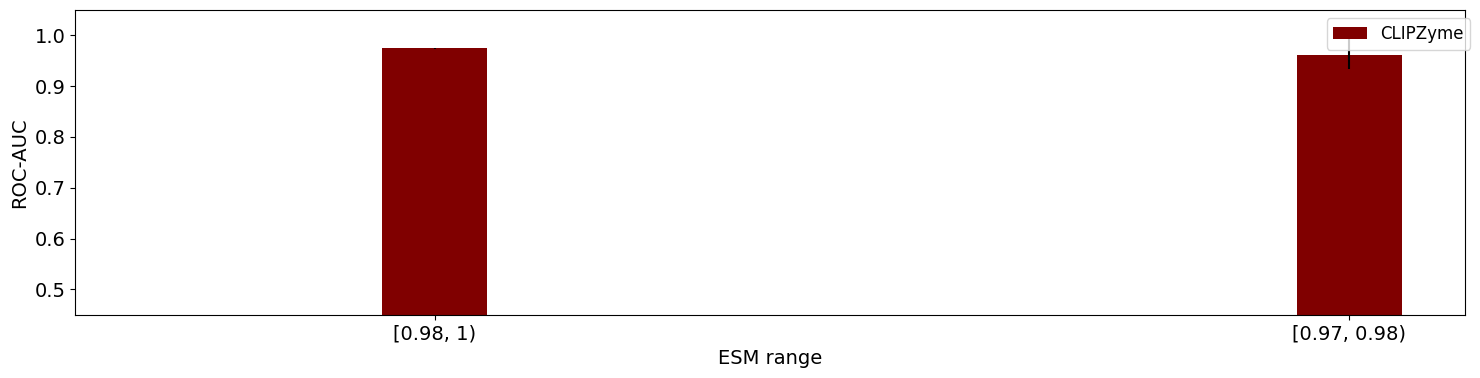

esm 5


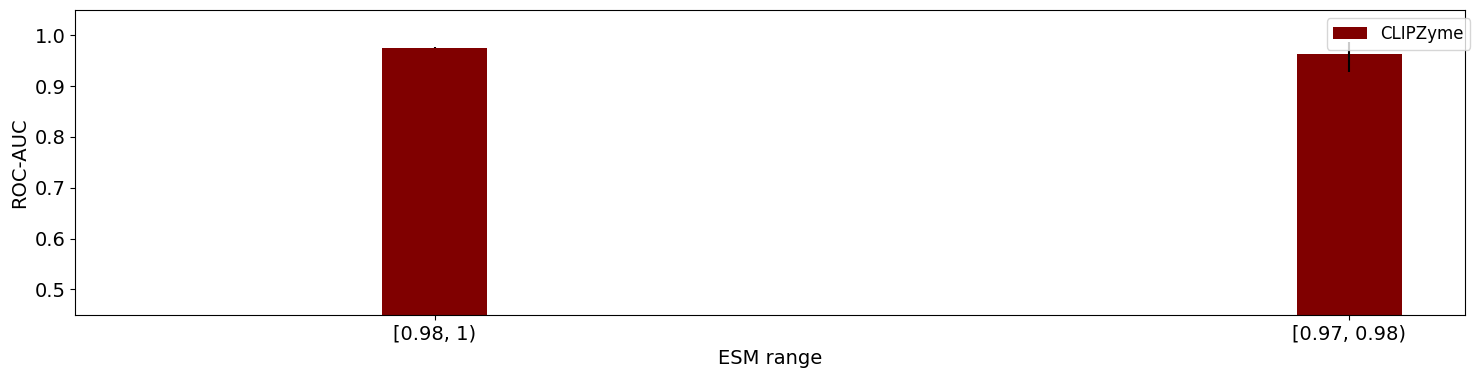

esm 10


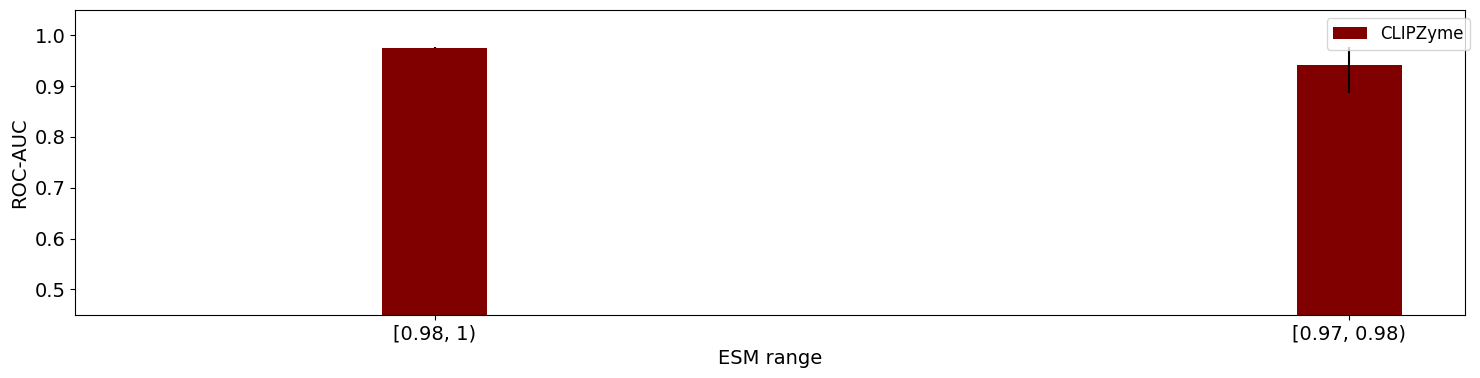

rcmcs 1


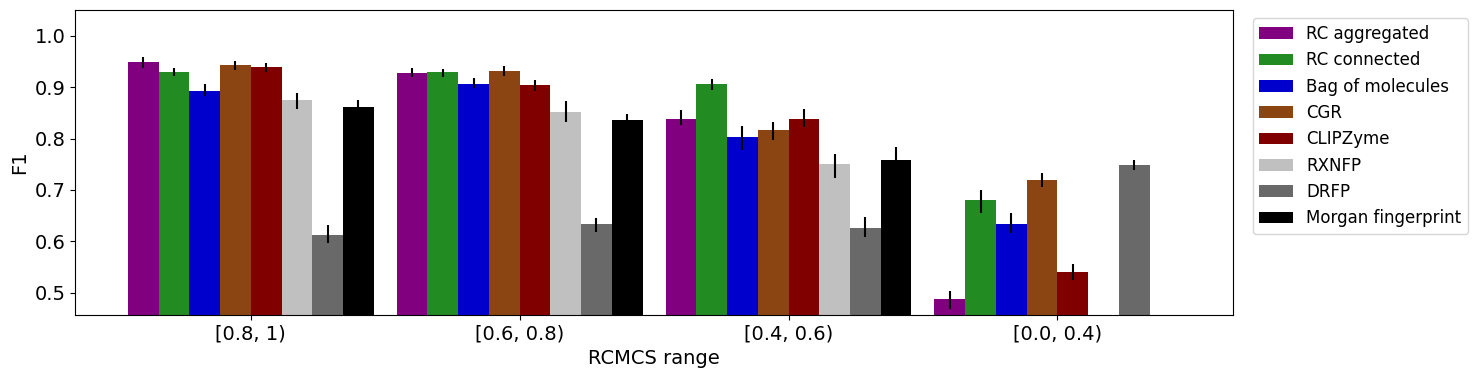

rcmcs 3


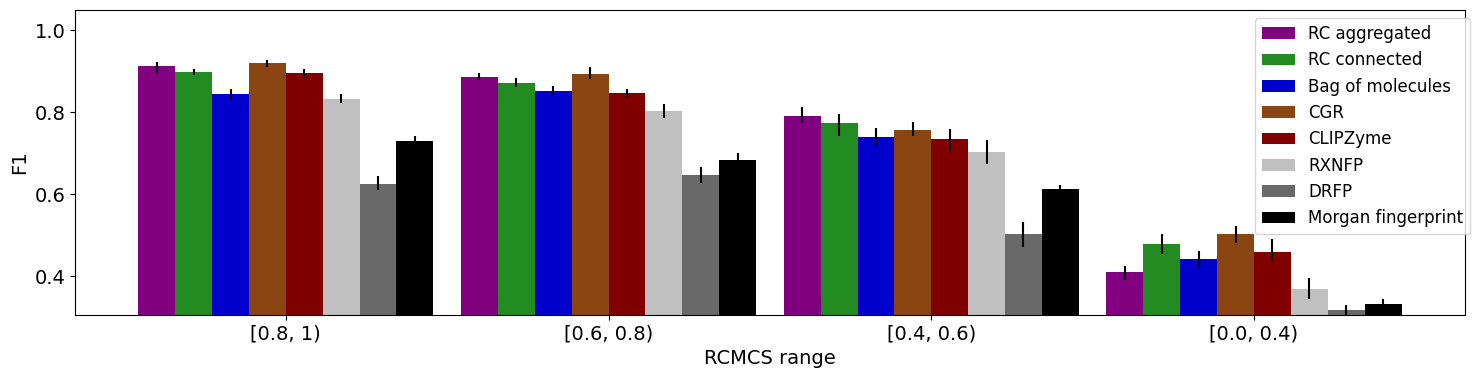

rcmcs 5


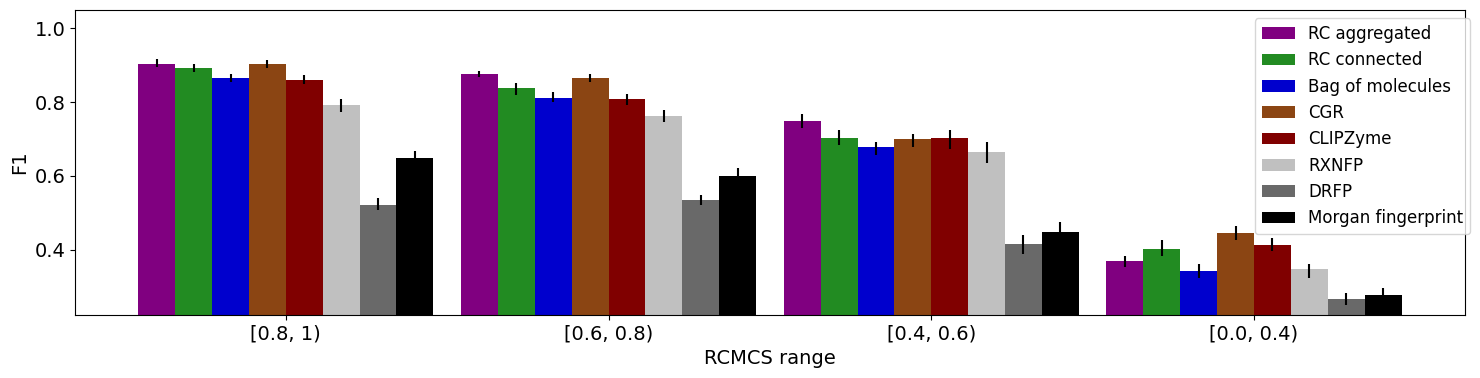

rcmcs 10


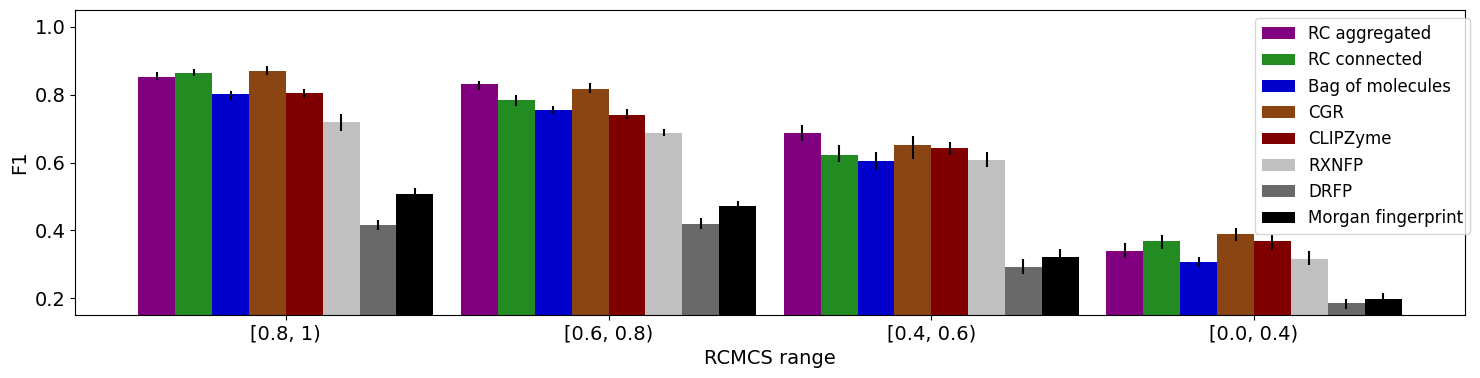

rcmcs 1


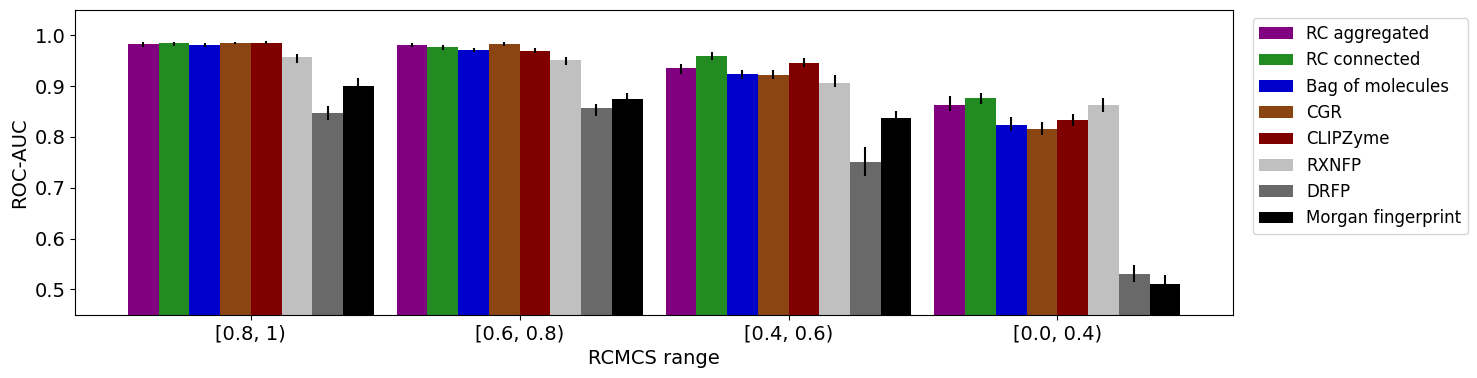

rcmcs 3


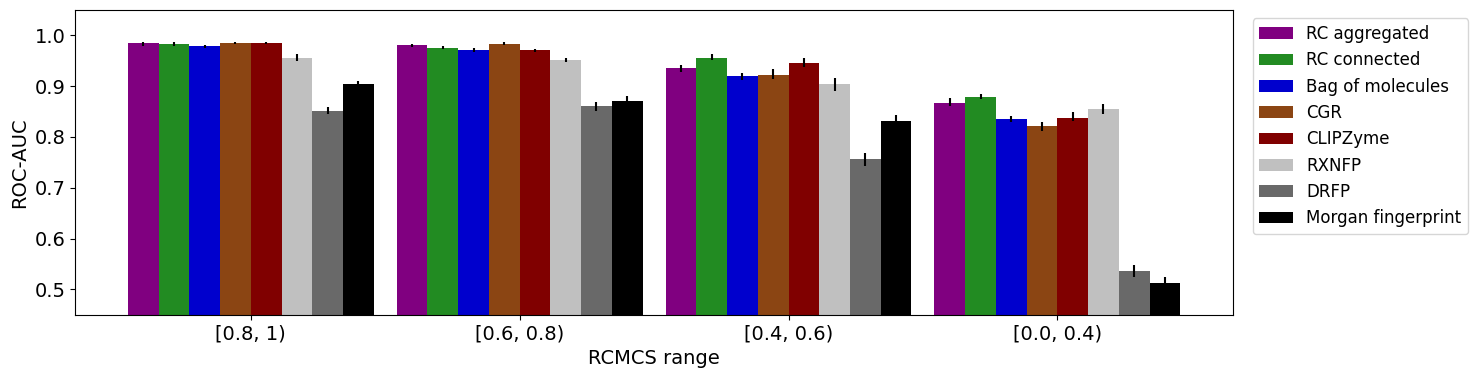

rcmcs 5


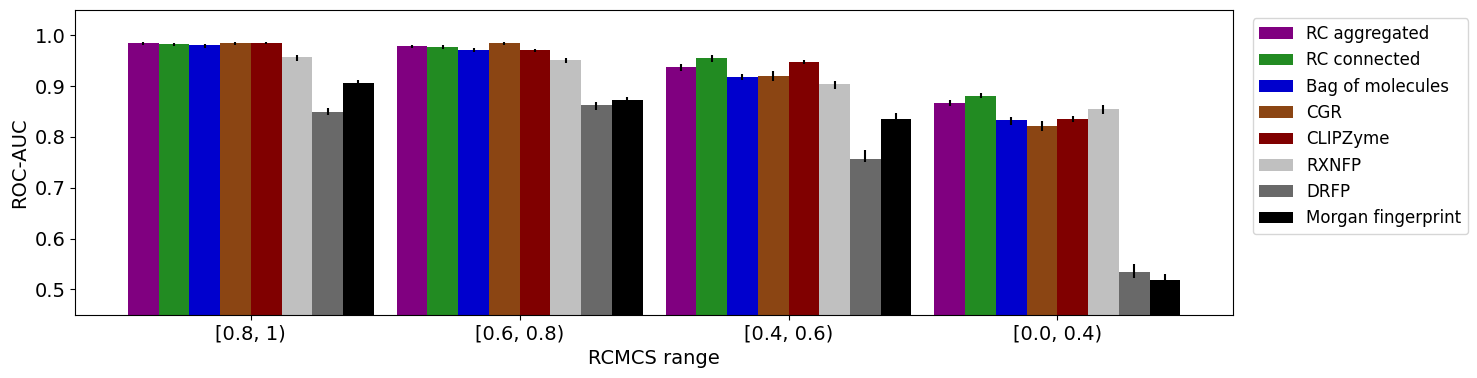

rcmcs 10


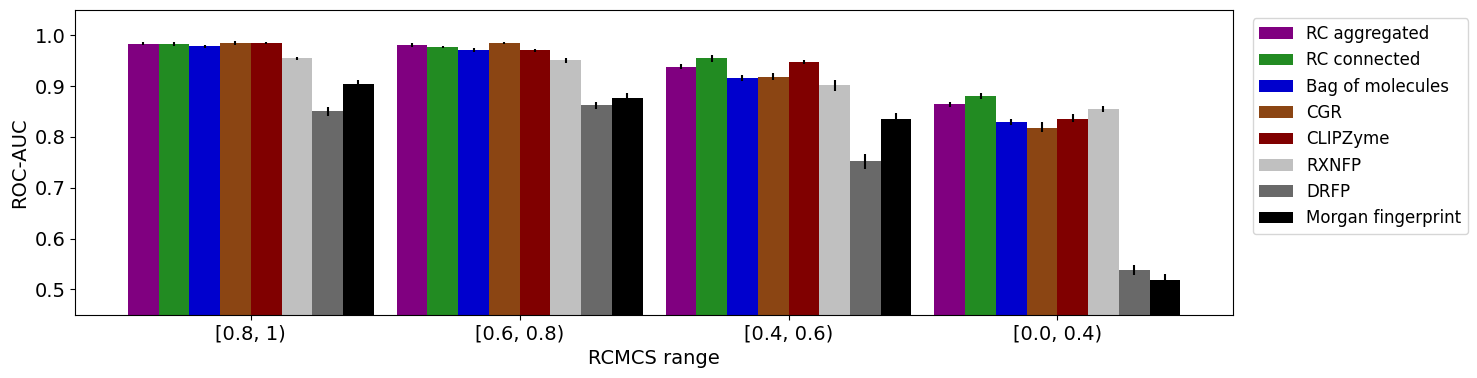

In [22]:
for (strat, metric_k, nm), df in split_metrics_table.groupby(['data', 'metric', 'neg_multiple']):
    if metric_k not in metrics_of_i:
        continue
    print(strat, nm)
    fig, ax = plt.subplots(figsize=figsize, sharey=True)
    for (lb, ub), bunch in df.groupby('sim_split'):
        j = 0
        offset = (len(bunch) / 2) * width
        for _, row in bunch.sort_values(by='model', key=get_model_order).iterrows():
            x = sim_split_bins[strat].index(row['sim_split']) * space
            model_name = row['model']
            val = row['mean']
            ci = np.array([row['mean'] - row['ci_lower'], row['ci_upper'] - row['mean']]).reshape(2, 1)
            ax.bar(x=x - offset + width * j, height=val, yerr=ci, width=width, color=colors[model_name])
            j += 1

    for key in bunch.sort_values(by='model', key=get_model_order)['model']:
        ax.bar(0, 0, color=colors[key], label=labels[key])
    
    # ax.set_ylim(*ylim[strat])
    _chance = chance.get((strat, nm, metric_k), 0.5)
    ax.set_ylim(scl_chance * _chance, 1.05)
    ax.set_xticks(np.arange(len(sim_split_bins[strat])) * space - width / 2)
    ax.set_xticklabels(bins2labels(sim_split_bins[strat]))
    ax.set_ylabel(metric_names[metric_k])
    ax.set_xlabel(f"{similarity_names[strat]} range")
    ax.legend(bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout()
    plt.savefig(save_to / "by_split" / f"{strat}_nm{nm}_similarity_clustered_{metric_names[metric_k]}.svg")
    plt.show()
            

In [23]:
split_metrics_table.loc[
    (split_metrics_table['data'] == 'rcmcs') &
    (split_metrics_table['neg_multiple'] == 10) &
    (split_metrics_table['metric'] == 'roc_auc') &
    (split_metrics_table['sim_split'] == (0, 0.4))
].sort_values(by='mean', ascending=False)

data     model  neg_multiple   sim_split   metric      mean  ci_lower  \
399  rcmcs    rc_cxn            10  (0.0, 0.4)  roc_auc  0.881297  0.874152   
479  rcmcs    rc_agg            10  (0.0, 0.4)  roc_auc  0.865371  0.859875   
79   rcmcs     rxnfp            10  (0.0, 0.4)  roc_auc  0.855961  0.848402   
639  rcmcs  clipzyme            10  (0.0, 0.4)  roc_auc  0.835565  0.829073   
559  rcmcs       bom            10  (0.0, 0.4)  roc_auc  0.828740  0.824357   
239  rcmcs       cgr            10  (0.0, 0.4)  roc_auc  0.817827  0.809214   
159  rcmcs      drfp            10  (0.0, 0.4)  roc_auc  0.538651  0.528956   
319  rcmcs       mfp            10  (0.0, 0.4)  roc_auc  0.518120  0.506889   

     ci_upper                                                id  
399  0.887325                  af29e2f62cf34bf2824dc8c72e086da5  
479  0.869684                  da9ed201898a451a8a822cf1a30ec30b  
79   0.861891                  bafce811361c4d19afe7919fb4666fb2  
639  0.845117  clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold  
559  0.834544                  d1a3cc3f1d36488e8222efda0d595914  
239  0.829413                  e627a08cec3c47e18b4fd9f1ade6b9fe  
159  0.547601                  36a93d8131bd460599ef98740f8d322d  
319  0.531118                  04cc886dade64a68a84b151ddd92cef2

In [39]:
id2name

{'000fc5f378954a27bf934ccd58241a57': {'data': 'random_reaction',
  'model': 'rxnfp'},
 'bafce811361c4d19afe7919fb4666fb2': {'data': 'rcmcs', 'model': 'rxnfp'},
 'f1cf506a0c0f48b49bbf491f51db24f7': {'data': 'random_reaction_center',
  'model': 'rxnfp'},
 'c4fdab61494a4affb7b48b3f18b0a314': {'data': 'random_reaction',
  'model': 'drfp'},
 'a91ff6acc5a848f18a179c42f5127a85': {'data': 'random_reaction_center',
  'model': 'drfp'},
 '36a93d8131bd460599ef98740f8d322d': {'data': 'rcmcs', 'model': 'drfp'},
 '120f090f4b3e471a965979401b3271ae': {'data': 'random_reaction',
  'model': 'cgr'},
 '34cda1e3f64a4b18a98894ed0e86be86': {'data': 'random_reaction_center',
  'model': 'cgr'},
 'e627a08cec3c47e18b4fd9f1ade6b9fe': {'data': 'rcmcs', 'model': 'cgr'},
 '7e836b6654ac4b9aba81fe692b059c5d': {'data': 'random_reaction',
  'model': 'mfp'},
 'ec2310e5872f47de8b9c81d1edce26b9': {'data': 'random_reaction_center',
  'model': 'mfp'},
 '04cc886dade64a68a84b151ddd92cef2': {'data': 'rcmcs', 'model': 'mfp'},
 '5

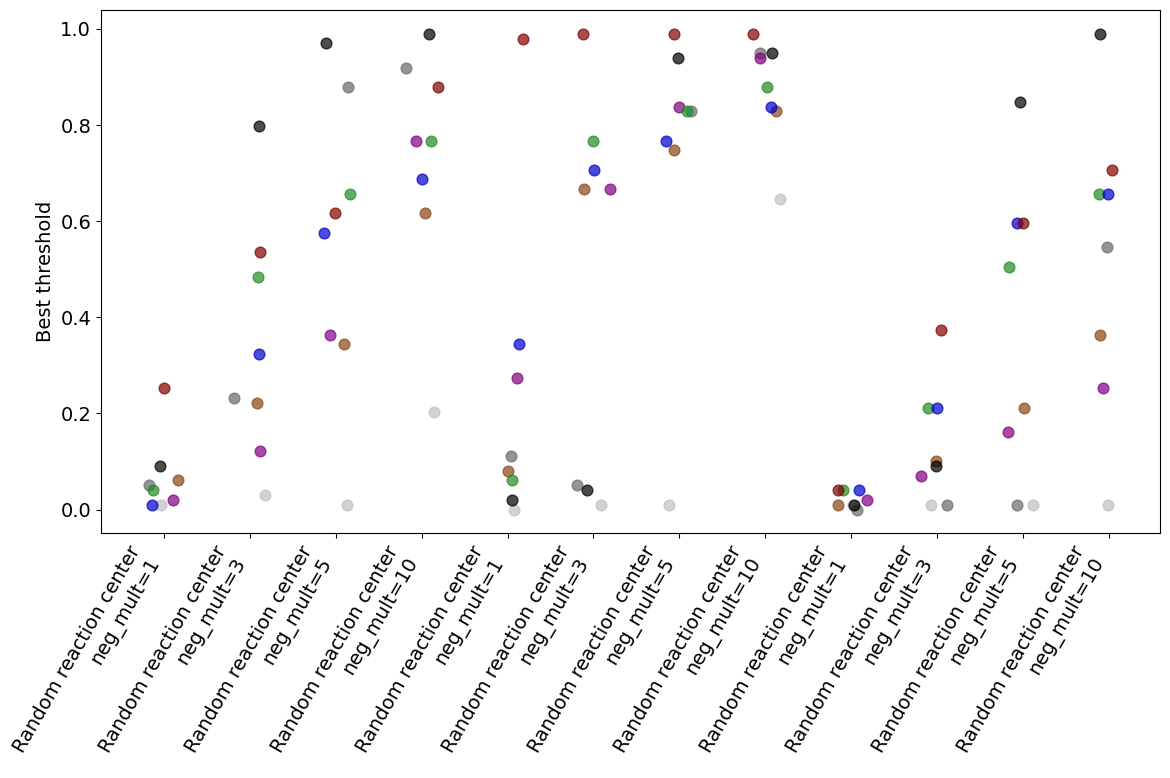

In [40]:
# Collect thresholds for each (data, neg_multiple, model) combo
blacklist = ['drfp', 'esm']
scatter_data = []
for id, name in id2name.items():
    for nm, th in best_thresholds.get(id, {}).items():
        if name['data'] in blacklist:
            continue
        scatter_data.append((name['data'], nm, name['model'], th))

# Prepare unique (data, neg_multiple) combos and mapping
combos = sorted(set((d, nm) for d, nm, _, _ in scatter_data))
combo2x = {combo: i for i, combo in enumerate(combos)}

plt.figure(figsize=(max(8, len(combos)), 8))
for d, nm, m, th in scatter_data:
    condition_name = similarity_names.get(d, d)
    x = combo2x[(d, nm)] + np.random.uniform(-0.2, 0.2)
    plt.scatter(x, th, alpha=0.7, s=60, label=m, color=colors.get(m, 'gray'))

plt.xticks(
    range(len(combos)),
    [f"{condition_name}\nneg_mult={nm}" for d, nm in combos],
    rotation=60,
    ha='right'
)
plt.ylabel("Best threshold")
plt.tight_layout()
plt.savefig("/home/stef/hiec/artifacts/figures/methods/best_thresholds_scatter.svg")
plt.show()


In [25]:
# Add best_thresholds column to metrics_table by looking up (runid, neg_multiple) in best_thresholds dict
metrics_table['best_thresholds'] = metrics_table.apply(
    lambda r: best_thresholds.get(r['id'], {}).get(int(r['neg_multiple']), np.nan),
    axis=1
)

metrics_table.head()

data  model  neg_multiple            metric      mean  ci_lower  \
0  random_reaction  rxnfp             1                f1  0.762303  0.756011   
1  random_reaction  rxnfp             1  binary_precision  0.877243  0.870906   
2  random_reaction  rxnfp             1     binary_recall  0.672218  0.665041   
3  random_reaction  rxnfp             1          accuracy  0.788941  0.781617   
4  random_reaction  rxnfp             1           roc_auc  0.886177  0.882454   

   ci_upper                                id  best_thresholds  
0  0.770053  000fc5f378954a27bf934ccd58241a57         0.010101  
1  0.883384  000fc5f378954a27bf934ccd58241a57         0.010101  
2  0.678269  000fc5f378954a27bf934ccd58241a57         0.010101  
3  0.793420  000fc5f378954a27bf934ccd58241a57         0.010101  
4  0.889128  000fc5f378954a27bf934ccd58241a57         0.010101

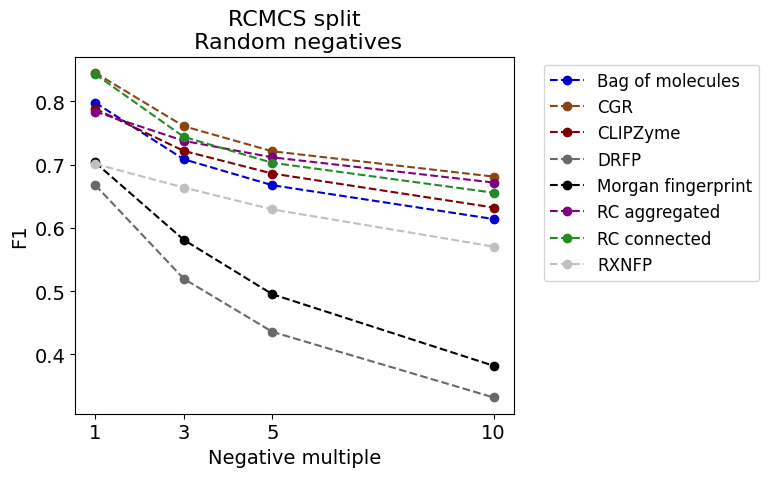

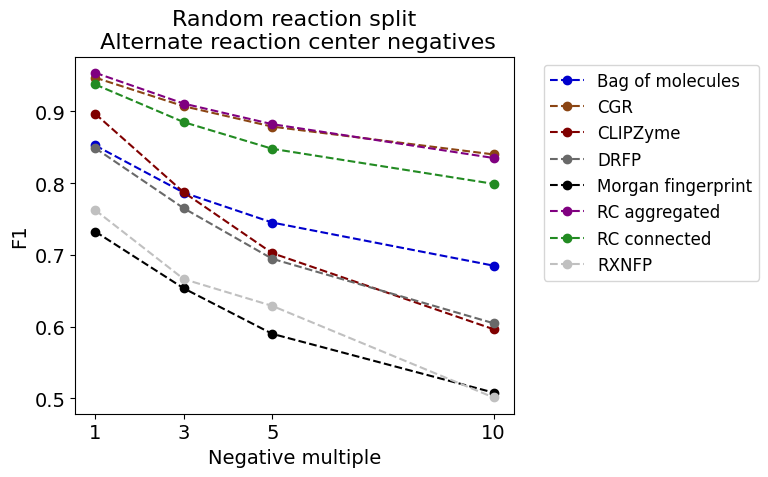

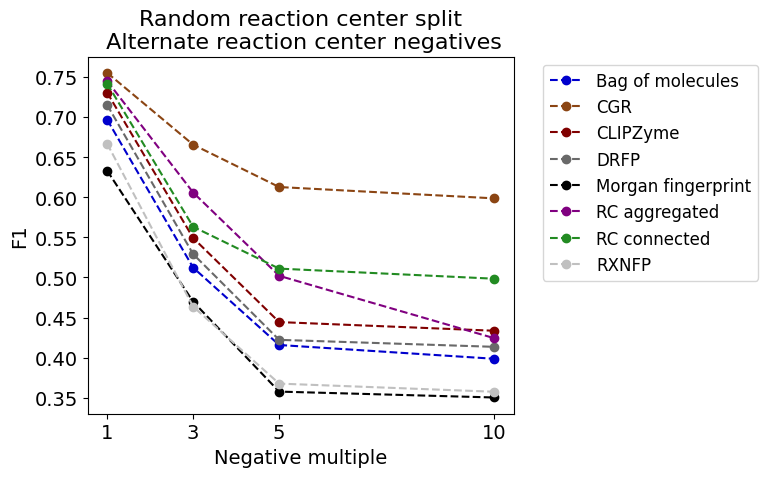

No f1 rows for homology, skipping.


In [26]:

# Line plots: F1 vs negative multiple for selected split strategies

strategies = ["rcmcs", "random_reaction", "random_reaction_center", "homology"]

for strat in strategies:
    df = metrics_table[(metrics_table['data'] == strat) & (metrics_table['metric'] == 'f1')]
    if df.empty:
        print(f"No f1 rows for {strat}, skipping.")
        continue

    pivot = df.pivot_table(index='neg_multiple', columns='model', values='mean')
    neg_mults = sorted(pivot.index.tolist())

    fig, ax = plt.subplots(figsize=(8, 5))
    for model in pivot.columns:
        y = pivot[model].reindex(neg_mults).values
        col = colors.get(model, 'gray')
        ax.plot(neg_mults, y, marker='o', linestyle='--', color=col, label=labels.get(model, model))

    ax.set_xlabel("Negative multiple")
    ax.set_ylabel("F1")
    ax.set_title(f"{similarity_names.get(strat, strat)} split\n {'Random' if strat in ['rcmcs', 'homology'] else 'Alternate reaction center'} negatives")
    ax.set_xticks(neg_mults)
    ax.legend(bbox_to_anchor=(1.05, 1.0))
    plt.tight_layout()
    plt.savefig(save_to.parent / "methods" / f"{strat}_f1_vs_neg_multiple.svg")
    plt.show()

In [27]:
metrics_table.to_csv(Path(filepaths.artifacts) / "evaluation_metrics.csv", sep=',', index=False)
split_metrics_table.to_csv(Path(filepaths.artifacts) / "evaluation_metrics_by_similarity_split.csv", sep=',', index=False)

In [28]:
from collections import defaultdict

# Check if indices are identical for each (data, neg_multiple) combo across models

# Group indices by (data, neg_multiple)
combo_indices = defaultdict(list)
for id, nm_dict in nm_keep_indices.items():
    data = id2name[id]['data']
    for nm, idxs in nm_dict.items():
        combo_indices[(data, nm)].append((id, idxs))

# Report mismatches
for combo, id_idx_list in combo_indices.items():
    # Use the first set of indices as reference
    ref_idxs = id_idx_list[0][1]
    for id, idxs in id_idx_list[1:]:
        if not np.array_equal(ref_idxs, idxs):
            print(f"Mismatch for {combo} between models: {id_idx_list[0][0]} and {id}")
        else:
            print(f"Indices match for {combo} between models: {id_idx_list[0][0]} and {id}")

Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and c4fdab61494a4affb7b48b3f18b0a314
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 120f090f4b3e471a965979401b3271ae
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 7e836b6654ac4b9aba81fe692b059c5d
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 55c062d229394c4f82828814300c0f2b
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 56c0235555af4e4c98dd6293c824cc2f
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and 1d6c62f5f2d44b3fa82851639fb44ead
Indices match for ('random_reaction', 1) between models: 000fc5f378954a27bf934ccd58241a57 and clipzyme/sprhea_v3_folded_pt_ns_random_reaction_outer_fold
Indices match for ('random_reaction', 3) between models: 000fc5f378954a27bf934ccd5824